In [1194]:
using PyPlot

   Resolving package versions...
   Installed PyCall ─ v1.96.4
   Installed PyPlot ─ v2.11.5
    Updating `~/.julia/environments/v1.10/Project.toml`
  [d330b81b] + PyPlot v2.11.5
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [438e738f] + PyCall v1.96.4
  [d330b81b] + PyPlot v2.11.5
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/9816a3826b0ebf49ab4926e2b18842ad8b5c8f04/build.log`
Precompiling project...
  ✓ PyCall
  ✓ SciMLBase → SciMLBasePyCallExt
  ✓ PyPlot
  3 dependencies successfully precompiled in 11 seconds. 447 already precompiled. 33 skipped during auto due to previous errors.


In [11]:
using JuMP, Ipopt, Plots, Printf, LinearAlgebra, SCS, COSMO, Distributions, LightGraphs

# Calculate $N$, $n_I$, $n_t$, $n_s$, $n_p$ and all possible states and target states

In [1116]:
N = 2
λ = 0.1

0.1

In [1117]:
function varioussizes(N)
    ni = 4 * (N + 1)^2
    np = 5 * N + 2
    ns  = ni - 12
    nt = np + ns + 1
    return ni,np,ns,nt
end

varioussizes (generic function with 1 method)

In [1118]:
varioussizes(2)

(36, 12, 24, 37)

In [1119]:
ni,np,ns,nt=varioussizes(N)

(36, 12, 24, 37)

In [1120]:
function statematrices(N)
    ni,np,ns,nt=varioussizes(N)
    S = Dict()
    T = [];
    TG = [];
    TB = [];
    for ua in 0:N
        for ub in 0:N
            for sa in 0:1
                for sb in 0:1
                    index = (2 * sa + sb) * (N + 1)^2 + (N + 1) * ua + ub
                    S[index] = (ua, ub, sa, sb)
                end
            end
        end
    end
    Skeyer = Dict(value => key for (key, value) in S);
    for ua in 0:N
        for ub in 0:N
            for sa in 0:1
                for sb in 0:1
                    i = (2 * sa + sb) * (N + 1)^2 + (N + 1) * ua + ub
                    if ua == N && ub == 0
                        push!(TG, i)
                        push!(T, i)
                    end
                    if ua == 0 && ub == N
                        push!(TG, i)
                        push!(T, i)
                    end
                    if ua == N && ub == N
                        push!(TB, i)
                        push!(T, i)
                    end
                end
            end
        end
    end
    Tc = [i for i in 0:ni-1 if i ∉ T];
    return S,Skeyer,T,TG,TB,Tc
end


statematrices (generic function with 1 method)

In [1121]:
S,Skeyer,T,TG,TB,Tc=statematrices(N);

# Solving the Original problem using a non-linear solver


The function below finds the hitting time given a rate matrix Q and a list of target states and start states.

In [1122]:
function hitting_time(Q,targetstates_good,targetstates_bad,startstates,λ)
    n=size(Q,1)
    A=copy(Q)
    b=-ones(n)
    targetstates=[targetstates_good;targetstates_bad]
    for target_state ∈ targetstates
        A[target_state, :] .= 0.0
        A[target_state, target_state] = 1.0
        if(target_state ∈ targetstates_good)
            b[target_state] = 0.0
        else
            b[target_state] = λ
        end
    end
    for i in 1:n
        if all(Q[i, :] .== 0.0) && i ∉ targetstates
            A[i, :] .= 0.0
            A[i, i] = 1.0
            b[i] = 0.0
        end
    end
    T = A \ b
    for i in 1:n
        if T[i]==0 && i ∉ targetstates
            T[i]=Inf 
        end
    end
    return [T[start_state] for start_state ∈ startstates]
end

hitting_time (generic function with 1 method)

Another useful tool would be to get a function that, given rate-matrix $Q$, checks if the CTMC is irreducible or not.

In [1123]:
function is_irreducible(Q::Matrix{Float64})
    n = size(Q, 1)
    G = SimpleDiGraph(n) 
    for i in 1:n
        for j in 1:n
            if i != j && Q[i, j] > 0
                add_edge!(G, i, j)
            end
        end
    end
    return is_strongly_connected(G)
end

is_irreducible (generic function with 1 method)

We try seeing if the above works for two specific small examples, and realise that it does work

In [1124]:
Q = [-1.0  0.5  0.5  0.0;
      0.25 -0.5  0.0  0.25;
      1/6  0.0  -1/3  1/6;
      0.0  0.0  0.0  0.0]
println(is_irreducible(Q))
println(hitting_time(Q,[3],[],[1,2,3,4],0))

false
[2.666666666666667, 3.3333333333333335, 0.0, Inf]


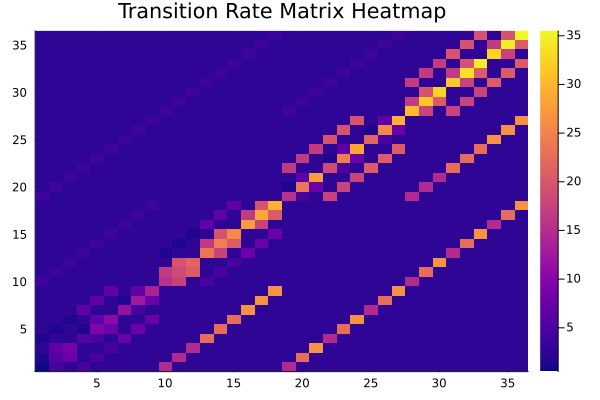

In [1158]:
heatmap(Q, c=:plasma, title="Transition Rate Matrix Heatmap")

In [21]:
Q = [-1.0  0.5  0.5  0.0  0.0;
      0.25 -0.75  0.25  0.25  0.0;
      0.25  0.0  -0.5  0.25  0.0;
      0.25  0.25  0.25 -0.75  0.0;
      0.0   0.0   0.0  0.0   0.0]
println(is_irreducible(Q))
println(hitting_time(Q,[4,5],[],[1,2,3],0))

false
[6.0, 5.0, 5.0]


Another useful function to code up would be one that simulates a CTMC given the rate matrix

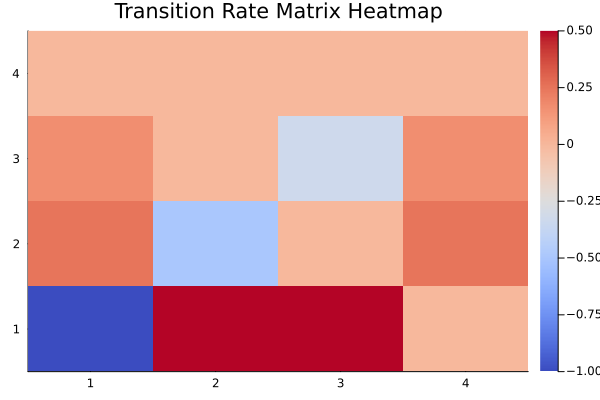

In [1131]:
heatmap(Q, c=:coolwarm, title="Transition Rate Matrix Heatmap")

In [1153]:
function simulate_ctmc(Q::Array{Float64,2}, initial_state::Int, T::Float64)
    num_states = size(Q, 1)
    t = 0.0
    s = initial_state
    times = [t]
    states = [s]
    tolerance = 1e-9

    while t < T
        λ = -Q[s, s]
        if λ < -tolerance
            error("Rate out of current state is negative at state $s.")
        elseif λ == 0
            println("There is an absorbing state at state $s.")
            break
        end

        Δt = rand(Exponential(λ))
        t += Δt
        if t >= T
            break
        end

        rates = copy(Q[s, :])
        rates[s] = 0.0
        total_rate = sum(rates)
        if total_rate <= 0
            error("No transitions available from current state $s.")
        end

        probs = rates / total_rate
        dist = Categorical(probs)
        s = rand(dist)
        push!(times, t)
        push!(states, s)
    end

    if times[end] < T
        push!(times, T)
        push!(states, states[end])
    end

    return times, states
end


simulate_ctmc (generic function with 1 method)

In [1154]:
function plot_ctmc(times::Vector{Float64}, states::Vector{Int}, T::Float64)
    plot(
        xlabel="Time", 
        ylabel="State", 
        title="CTMC Simulation",
        yticks=collect(1:maximum(states)),
        xlim=(0, T), 
        ylim=(minimum(states)-0.5, maximum(states)+0.5),
        grid=:both
    )
    
    for i in 1:(length(times)-1)
        plot!([times[i], times[i+1]], [states[i], states[i]], linewidth=2, label=false)
        if i < length(times)-1
            plot!([times[i+1], times[i+1]], [states[i], states[i+1]], linestyle=:dash, color=:gray, label=false)
        end
    end

    display(current())
end


plot_ctmc (generic function with 1 method)

Now we focus on our case. First we attempt to build $Q$. We do so in two ways. One is to construct it using definition. And the second is to use our 3-tensor.

In [22]:
function Q_maker(P,N::Int64,λ::Float64,S,Skeyer)
    ni,np,ns,nt=varioussizes(N)
    # Q=@expression(model, zeros(AffExpr, ni, ni)) 
    Q=zeros(ni,ni)
    for (u, u_) in Iterators.product(values(S), values(S))
        if u == u_
            continue
        end
        i = Skeyer[u]
        j = Skeyer[u_]
        flag = 0
        tempk = 0
        ua, ub, sa, sb = u
        ua_, ub_, sa_, sb_ = u_
    
        if ua_==ua+1 && ub == ub_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = N * sa + ua + 1
        elseif ua_==ua-1 && ub == ub_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = sa * N + ua + 2 * N 
        elseif ub_==ub+1 && ua == ua_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = N * sb + ub + 1
        elseif ub_==ub-1 && ua == ua_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = sb * N + ub + 2 * N 
        elseif ua == ua_ && ub == ub_ && sb == sb_ && sa==0 && sa_==1
            flag = 1
            tempk = 4 * N + ub + 1
        elseif ua == ua_ && ub == ub_ && sb == sb_ && sa==1 && sa_==0
            flag = 1
            tempk = 5 * N + 2
        elseif ua == ua_ && ub == ub_ && sa == sa_ && sb==0 && sb_==1
            flag = 1
            tempk = 4 * N + ua + 1
        elseif ua == ua_ && ub == ub_ && sa == sa_ && sb==1 && sb_==0
            flag = 1
            tempk = 5 * N + 2
        end
        if flag == 1
            Q[i+1, j+1] = P[tempk]
        end
    end

    for i in 1:ni
        # Calculate the sum of each row for Qi
        qi = sum(Q[i, :])
        Q[i,i] = -qi
    end
    return Q
    
end


Q_maker (generic function with 1 method)

In [23]:
function M_maker(N::Int64,λ::Float64,S,Skeyer)
    ni,np,ns,nt=varioussizes(N)
    M=zeros(Int, ni, ni, np);
    for (u, u_) in Iterators.product(values(S), values(S))
        # Skip if u and u_ are the same
        if u == u_
            continue
        end

        i = Skeyer[u]
        j = Skeyer[u_]
        flag = 0
        ua, ub, sa, sb = u
        ua_, ub_, sa_, sb_ = u_

        tempk = 0

        if ua_==ua+1 && ub == ub_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = N * sa + ua + 1
        elseif ua_==ua-1 && ub == ub_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = sa * N + ua + 2 * N 
        elseif ub_==ub+1 && ua == ua_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = N * sb + ub + 1
        elseif ub_==ub-1 && ua == ua_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = sb * N + ub + 2 * N 
        elseif ua == ua_ && ub == ub_ && sb == sb_ && sa==0 && sa_==1
            flag = 1
            tempk = 4 * N + ub + 1
        elseif ua == ua_ && ub == ub_ && sb == sb_ && sa==1 && sa_==0
            flag = 1
            tempk = 5 * N + 2
        elseif ua == ua_ && ub == ub_  && sa == sa_ && sb==0 && sb_==1
            flag = 1
            tempk = 4 * N + ua + 1
        elseif ua == ua_ && ub == ub_ && sa == sa_ && sb==1 && sb_==0
            flag = 1
            tempk = 5 * N + 2
        end

        if flag == 1
            M[i+1, j+1, tempk] = flag
        end
    end
    for k in 1:np
        # Calculate the sum of each row for the kth slice of M (equivalent to M[:,:,k] in Python)
        M_i = [sum(M[:, :, k][i, :]) for i in 1:ni]

        for u in values(S)
            i = Skeyer[u]
            M[i+1, i+1, k] = -M_i[i+1]
        end
    end
    
    return M
end


M_maker (generic function with 1 method)

In [24]:
function Q_maker_using_M(P,N::Int64,λ::Float64,S,Skeyer)
    ni,np,ns,nt=varioussizes(N)
    M=M_maker(N::Int64,λ::Float64,S,Skeyer)
    Q = reduce((x, y) -> x + y, [P[k] * M[:, :, k] for k in 1:np])
    return Q
end

Q_maker_using_M (generic function with 1 method)

## Check that Q_makers work

We now check if the above Q_maker functions agree with each other. To do so, first, we create a random paramter vector $\mathbf{P}$

In [25]:
f⁺=rand(N, 2)
f⁻=rand(N, 2)
f⁺_flattened = collect(Iterators.flatten(f⁺'))
f⁻_flattened = collect(Iterators.flatten(f⁻'))
g=rand(N+1)
koff=rand(Uniform(0,1))
P = collect(vcat(f⁺_flattened, f⁻_flattened, g, [koff]));

In [26]:
maximum(abs.(Q_maker_using_M(P,N,λ,S,Skeyer)-Q_maker(P,N,λ,S,Skeyer)))

4.440892098500626e-16

So they do agree to quite good accuracy??

Now given a random $\mathbf{P}$, let's try finding the hitting times??

Is Q irreducible? true


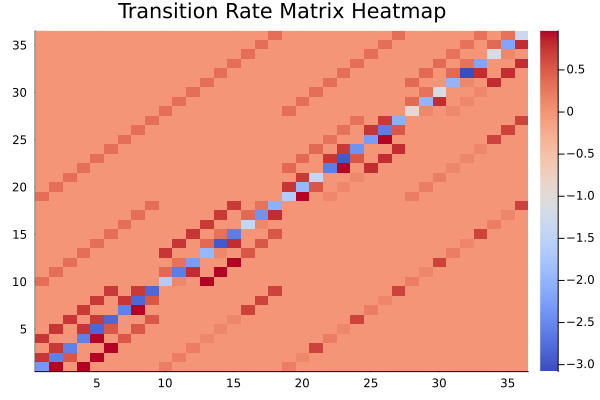

In [1132]:
f⁺=rand(N, 2)
f⁻=rand(N, 2)
f⁺_flattened = collect(Iterators.flatten(f⁺'))
f⁻_flattened = collect(Iterators.flatten(f⁻'))
g=rand(N+1)
koff=rand(Uniform(0,1))
P = collect(vcat(f⁺_flattened, f⁻_flattened, g, [koff]))
Q=Q_maker_using_M(P,N,λ,S,Skeyer)
println("Is Q irreducible? ", is_irreducible(Q))
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]
heatmap(Q, c=:coolwarm, title="Transition Rate Matrix Heatmap")

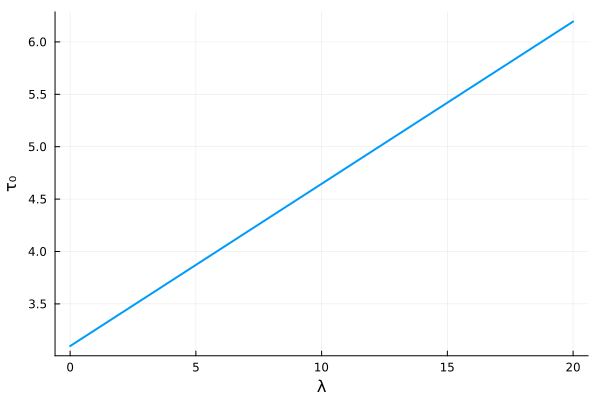

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda0.1_N3_P_rad_plot.png"

In [1133]:


λ_vals = range(0.0, stop=20.0, length=100)
τ_0_values = []
for λ_ in λ_vals
    τ_curr = hitting_time(Q, targetstates_good, targetstates_bad, allstates, λ_)
    # println(τ_curr[1])
    push!(τ_0_values, τ_curr[1])
end
display(plot(λ_vals, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda0.1_N3_P_rad_plot.png")



I am quite unsure why it is linear in $\lambda$ now, although I guess it makes sense

I guess this works????

## Find optimal $\mathbf{P}$ to minimise $\tau_0$

Now, we intend on trying to solve the optimisation problem in our project.
Before that, however, we should modify our functions so that we are working with AffExpr instead

In [1171]:
function Q_maker_original_mod(P,N::Int64,λ::Float64, model,S,Skeyer)
    ni,np,ns,nt=varioussizes(N)
    Q=@expression(model, zeros(AffExpr, ni, ni)) 
    for (u, u_) in Iterators.product(values(S), values(S))
        if u == u_
            continue
        end
        i = Skeyer[u]
        j = Skeyer[u_]
        flag = 0
        ua, ub, sa, sb = u
        ua_, ub_, sa_, sb_ = u_

        tempk = 0

        if ua_==ua+1 && ub == ub_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = N * sa + ua + 1
        elseif ua_==ua-1 && ub == ub_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = sa * N + ua + 2 * N 
        elseif ub_==ub+1 && ua == ua_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = N * sb + ub + 1
        elseif ub_==ub-1 && ua == ua_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = sb * N + ub + 2 * N 
        elseif ua == ua_ && ub == ub_ && sb == sb_ && sa==0 && sa_==1
            flag = 1
            tempk = 4 * N + ub + 1
        elseif ua == ua_ && ub == ub_ && sb == sb_ && sa==1 && sa_==0
            flag = 1
            tempk = 5 * N + 2
        elseif ua == ua_ && ub == ub_ && sa == sa_ && sb==0 && sb_==1
            flag = 1
            tempk = 4 * N + ua + 1
        elseif ua == ua_ && ub == ub_ && sa == sa_ && sb==1 && sb_==0
            flag = 1
            tempk = 5 * N + 2
        end
        if flag == 1
            Q[i+1, j+1] = P[tempk]
        end
    end
    for i in 1:ni
        # Calculate the sum of each row for Qi
        qi = sum(Q[i, :])
        Q[i,i] = -qi
    end
    return Q
end

Q_maker_original_mod (generic function with 1 method)

### Doing So directly (?)

In [1172]:
function hitting_time_mod(Q,targetstates_good,targetstates_bad,startstates,λ,model)
    #ugh for simplicity in writing this up, assume irreducible
    n=size(Q,1)
    A=copy(Q)
    b=-ones(n)
    targetstates=[targetstates_good;targetstates_bad]
    for target_state ∈ targetstates
        A[target_state, :] .= 0.0
        A[target_state, target_state] = 1.0
        if(target_state ∈ targetstates_good)
            b[target_state] = 0.0
        else
            b[target_state] = λ
        end
    end
    for i in 1:n
        if all(Q[i, :] .== 0.0) && i ∉ targetstates
            A[i, :] .= 0.0
            A[i, i] = 1.0
            b[i] = 0.0
        end
    end
    model2 = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model2, "print_level", 0)
    @variable(model2, T[1:n])
    @constraint(model2, A * T == b)
    # Solve the model
    optimize!(model2)

    # Get the hitting times
    T_vals = value.(T)
    # Handle infinite hitting times for unreachable states
    for i in 1:n
        if T_vals[i]==0 && i ∉ targetstates
            T_vals[i] = Inf
        end
    end

    return [T_vals[start_state] for start_state ∈ startstates]
end

hitting_time_mod (generic function with 1 method)

In [1173]:
function hitting_time_mod_give_A(Q,targetstates_good,targetstates_bad,startstates,λ,model)
    #ugh for simplicity in writing this up, assume irreducible
    n=size(Q,1)
    A=copy(Q)
    b=-ones(n)
    targetstates=[targetstates_good;targetstates_bad]
    for target_state ∈ targetstates
        A[target_state, :] .= 0.0
        A[target_state, target_state] = 1.0
        if(target_state ∈ targetstates_good)
            b[target_state] = 0.0
        else
            b[target_state] = λ
        end
    end
    for i in 1:n
        if all(Q[i, :] .== 0.0) && i ∉ targetstates
            A[i, :] .= 0.0
            A[i, i] = 1.0
            b[i] = 0.0
        end
    end
    return A
end

hitting_time_mod_give_A (generic function with 1 method)

In [1174]:
function hitting_time_mod_give_b(Q,targetstates_good,targetstates_bad,startstates,λ,model)
    #ugh for simplicity in writing this up, assume irreducible
    n=size(Q,1)
    A=copy(Q)
    b=-ones(n)
    targetstates=[targetstates_good;targetstates_bad]
    for target_state ∈ targetstates
        A[target_state, :] .= 0.0
        A[target_state, target_state] = 1.0
        if(target_state ∈ targetstates_good)
            b[target_state] = 0.0
        else
            b[target_state] = λ
        end
    end
    for i in 1:n
        if all(Q[i, :] .== 0.0) && i ∉ targetstates
            A[i, :] .= 0.0
            A[i, i] = 1.0
            b[i] = 0.0
        end
    end
    return b
end

hitting_time_mod_give_b (generic function with 1 method)

Let's check if this works!

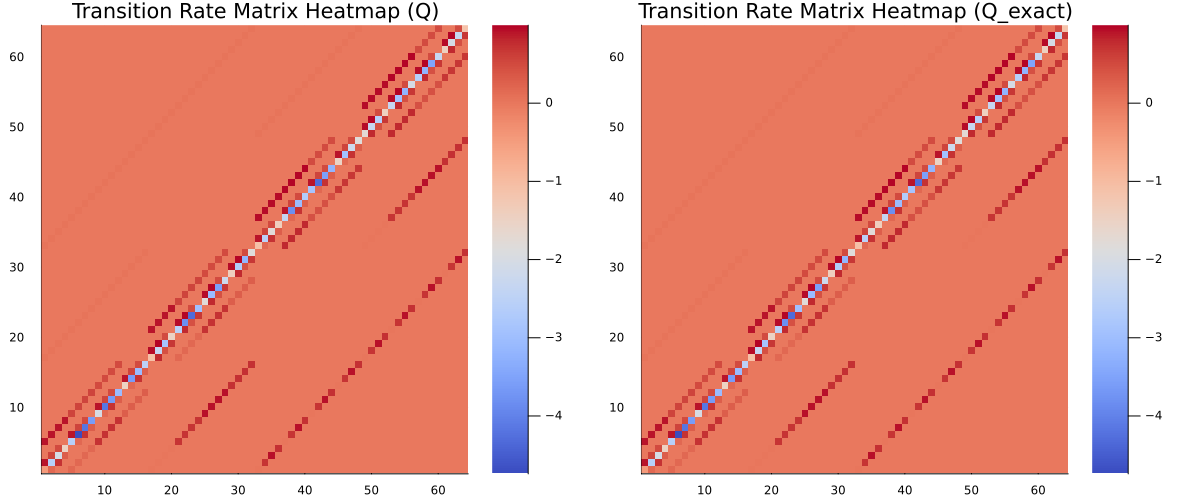

In [1175]:
model = Model(Ipopt.Optimizer)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
f⁺=rand(N, 2)
f⁻=rand(N, 2)
f⁺_flattened = collect(Iterators.flatten(f⁺'))
f⁻_flattened = collect(Iterators.flatten(f⁻'))
g=rand(N+1)
koff=rand(Uniform(0,1))
P = collect(vcat(f⁺_flattened, f⁻_flattened, g, [koff]))
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Q=Q_maker_original_mod(P,N,λ,model,S,Skeyer)
Q_exact=Q_maker(P,N,λ,S,Skeyer)
p1 = heatmap([value(q) for q in Q], c=:coolwarm, title="Transition Rate Matrix Heatmap (Q)")
p2 = heatmap(Q_exact, c=:coolwarm, title="Transition Rate Matrix Heatmap (Q_exact)")
plot(p1, p2, layout=(1, 2), size=(1200, 500))

In [1176]:
τ_actual=hitting_time(Q_exact,targetstates_good,targetstates_bad,allstates,λ)
τ_now=hitting_time_mod(Q,targetstates_good,targetstates_bad,allstates,λ,model)
println("maximum error: ",maximum(abs.(τ_actual-τ_now)))
println("τ_0,exact: ",τ_actual[1])
println("τ_0: ",τ_now[1])

maximum error: 1.5987211554602254e-14
τ_0,exact: 13.576766165247594
τ_0: 13.57676616524759


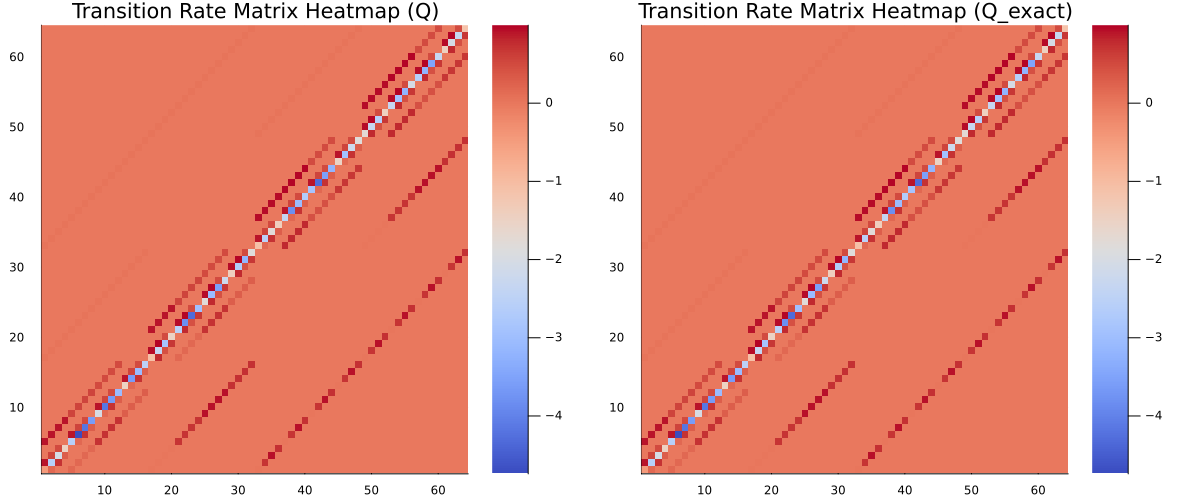

In [1177]:
model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "print_level", 0)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Q=Q_maker_original_mod(P,N,λ,model,S,Skeyer)
Q_exact=Q_maker(P,N,λ,S,Skeyer)
p1 = heatmap([value(q) for q in Q], c=:coolwarm, title="Transition Rate Matrix Heatmap (Q)")
p2 = heatmap(Q_exact, c=:coolwarm, title="Transition Rate Matrix Heatmap (Q_exact)")
plot(p1, p2, layout=(1, 2), size=(1200, 500))


In [1178]:
A=hitting_time_mod_give_A(Q,targetstates_good,targetstates_bad,allstates,λ,model)
b=hitting_time_mod_give_b(Q,targetstates_good,targetstates_bad,allstates,λ,model)

n=size(Q,1)
@variable(model, τ[1:n])
@constraint(model, A * τ == b)
optimize!(model)
τ_now=value.(τ)
for i in 1:n
    if τ_now[i]==0 && i ∉ targetstates
        τ_now[i] = Inf
    end
end
τ_final=[τ_now[state] for state ∈ allstates]
τ_actual=hitting_time(Q_exact,targetstates_good,targetstates_bad,allstates,λ)
println("maximum error: ",maximum(abs.(τ_actual-τ_final)))
println("τ_0,exact: ",τ_actual[1])
println("τ_0: ",τ_final[1])

maximum error: 1.5987211554602254e-14
τ_0,exact: 13.576766165247594
τ_0: 13.57676616524759


Seems to work! So let's try finding optimal $\mathbf{P}$

In [1190]:
#Assume statematrices(), varioussizes(), and Q_maker_original_mod() are defined elsewhere

N = 3
λ = 10.0
model = Model(Ipopt.Optimizer)

# Set solver tolerances and attributes
set_optimizer_attribute(model, "tol", 1e-12)
set_optimizer_attribute(model, "print_level", 0)

# Assuming statematrices() and varioussizes() are defined and return required values
S, Skeyer, T, TG, TB, Tc = statematrices(N)
ni, np, ns, nt = varioussizes(N)

# Define the target and start states, assuming +1 index shift for Julia's 1-based indexing
targetstates_good = [target_state + 1 for target_state in TG]
targetstates_bad = [target_state + 1 for target_state in TB]
targetstates = [targetstates_good; targetstates_bad]
startstates = [start_state + 1 for start_state in Tc]
allstates = [startstates; targetstates_good; targetstates_bad]

# Define decision variables (P_ is the vector over which we minimize)
@variable(model, 0 <= P_[1:np] <= 1)  # P_ is the vector of decision variables

# Define an auxiliary variable to represent τ[1]
@variable(model, τ_0)

# Define the expression for τ based on P_
@expression(model, A, hitting_time_mod_give_A(Q_maker_original_mod(P_, N, λ, model, S, Skeyer), 
               targetstates_good, targetstates_bad, allstates, λ, model))
@expression(model, b, hitting_time_mod_give_b(Q_maker_original_mod(P_, N, λ, model, S, Skeyer), 
               targetstates_good, targetstates_bad, allstates, λ, model))
println(size(A))
println(size(b))

@constraint(model, [i=1:ni], b[i] == A[i] * τ)exr[i])

# Make sure that any array-scalar operation is element-wise (e.g., τ_expr[1] .- τ_0 or τ_expr .- τ_0)
@constraint(model, τ_0 == τ_expr[1])  # Ensure element-wise operation

# Objective function: Minimize τ_0
@objective(model, Min, τ_0)

# Set the start values for P_ as initial guesses
for i in 1:np
    set_start_value(P_[i], 0.95)
end

# Solve the optimization problem
optimize!(model)

# Print the termination status of the solver
println(termination_status(model))

# Get the optimal P_ and τ values
P_opt = value.(P_)
tau_opt = value(τ_0)  # Now τ_0 is the actual variable minimized

# Print the optimal values
println("Optimal τ_0: ", tau_opt)  # τ_0 is now the optimized variable
println("Optimal P_: ", P_opt)


(64, 64)
(64,)


LoadError: VariableNotOwned{VariableRef}(τ[1]): the variable τ[1] cannot be used in this model because
it belongs to a different model.

## Explanation

Each variable belongs to a particular model. You cannot use a variable
inside a model to which it does not belong. For example:

```julia
model = Model()
@variable(model, x >= 0)
model2 = Model()
@objective(model2, Min, x)  # Errors because x belongs to `model`
```

One common cause of this error is working with a main problem and a
subproblem.

```julia
model = Model()
@variable(model, x, Bin)
subproblem = Model()
@variable(subproblem, 0 <= x <= 1)
# The Julia binding `x` now refers to `subproblem[:x]`, not `model[:x]`
@objective(model, Min, x)  # Errors because x belongs to `subproblem`
# do instead
@objective(model, Min, model[:x])
```

In [1192]:
N=3
λ=10.0
model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "tol", 1e-12)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
set_optimizer_attribute(model, "print_level", 0)
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

@variable(model, 0<=P_[1:np] <= 1) 
@variable(model, τ[1:ni]) 
@objective(model, Min, τ[1])
@expression(model, A, hitting_time_mod_give_A(Q_maker_original_mod(P_, N, λ, model, S, Skeyer), 
               targetstates_good, targetstates_bad, allstates, λ, model))
@expression(model, b, hitting_time_mod_give_b(Q_maker_original_mod(P_, N, λ, model, S, Skeyer), 
               targetstates_good, targetstates_bad, allstates, λ, model))
@constraint(model, A * τ == b)
for i in 1:np
    set_start_value(P_[i], 0.95)  # Initial guess for P_
end

for i in 1:ns
    set_start_value(τ[i], 1.0)   # Initial guess for τ
end  
optimize!(model)
println(termination_status(model))
P_opt=value.(P_);
tau_opt=value.(τ);
tau_opt[1]


LOCALLY_SOLVED


4.135700304083625

In [1114]:
P_opt_=P_opt.* (abs.(P_opt) .>= 1e-8)
P_opt_.= min.(P_opt_, 1.0)
for i=1:np
    println(P_opt_[i])
end
# f+(0,0)f+(1,0)f+(0,1)f+(1,1)

0.6239066121836075
1.0
1.0
-0.0
-0.0
0.028429844231703635
-0.0
-0.0
-0.0
1.0
1.0
-0.0
-0.0
1.0
1.0
1.0
0.20604439732175803


In [1047]:
P_opt_=P_opt.* (abs.(P_opt) .>= 1e-8)
P_opt_.= min.(P_opt_, 1.0)
Q_exact=Q_maker(P_opt_,N,λ,S,Skeyer)
τ_actual=hitting_time(Q_exact,targetstates_good,targetstates_bad,allstates,λ)
τ_actual[1]


4.363857048851752

In [1072]:
P_opt_perturbed = P_opt_ .+ 1e-2 .* randn(size(P_opt_))
P_opt_perturbed=P_opt_perturbed.* (abs.(P_opt) .>= 1e-8)
P_opt_perturbed .= min.(P_opt_perturbed, 1.0)
P_opt_perturbed .= max.(P_opt_perturbed, 0.0)
Q_exact=Q_maker(P_opt_perturbed,N,λ,S,Skeyer)
τ_actual=hitting_time(Q_exact,targetstates_good,targetstates_bad,allstates,λ)
println(τ_actual[1])
println(P_opt_)
println(P_opt_perturbed)

4.374802069391802
[1.0, 1.0, 1.0, 1.0, -0.0, -0.0, 1.0, 1.0, 0.45321567027567844, -0.0, -0.0, -0.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0, 1.0, 1.0, 1.0, 0.054229009926686896]
[1.0, 1.0, 0.9915929064252671, 1.0, 0.0, 0.0, 1.0, 1.0, 0.4654897348406959, 0.0, 0.0, 0.0, 1.0, 0.9869034125618773, 0.0, 0.0, 0.0, 0.0, 0.9998754826746712, 0.9916806218105533, 0.9950834475737426, 0.058578117965751235]


In [777]:
P_opt_=P_opt.* (abs.(P_opt) .>= 1e-8)

22-element Vector{Float64}:
  0.9999999197484328
  1.0000000072465147
  1.0000000073493418
  1.0000000071473154
 -0.0
  0.3799104323279427
  0.9999999938700959
  1.0000000007264818
  0.0
 -0.0
 -0.0
  3.931998133076123e-8
  1.0000000033414769
  0.999999724831234
  0.0
  0.0
 -0.0
  0.9999999674918817
  0.9999999968891613
  0.9999999957286382
  0.999999984068337
  0.15176757849609993

In [770]:
P_opt_=P_opt.* (abs.(P_opt) .>= 1e-8)

22-element Vector{Float64}:
  1.0000000035176315
  1.000000005969451
  1.0000000069517474
  1.0000000070465003
 -0.0
 -0.0
  0.9999997669105739
  0.9999999975906981
  0.45505366462393443
 -0.0
 -0.0
  0.0
  1.0000000011199444
  0.9999999865398761
  6.787789399476672e-8
  1.2860553727229181e-8
 -0.0
 -0.0
  1.0000000016809285
  0.9999999979092347
  0.999999983032821
  0.05417312622959018

In [207]:
N=4
λ=2.0
model = Model(Ipopt.Optimizer)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
f⁺=ones(N, 2) #rand(N, 2)
f⁻=zeros(N, 2) #rand(N, 2)
f⁺_flattened = collect(Iterators.flatten(f⁺'))
f⁻_flattened = collect(Iterators.flatten(f⁻'))
g= ones(N+1)#rand(N+1)
koff=rand(Uniform(0,1))
P = collect(vcat(f⁺_flattened, f⁻_flattened, g, [koff]))
println(P)
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Q=Q_maker_original_mod(P,N,λ,model,S,Skeyer)
Q_exact=Q_maker(P,N,λ,S,Skeyer)

τ_actual=hitting_time(Q_exact,targetstates_good,targetstates_bad,allstates,λ)
τ_now=hitting_time_mod(Q,targetstates_good,targetstates_bad,allstates,λ,model)
println("maximum error: ",maximum(abs.(τ_actual-τ_now)))
println("τ_0,exact: ",τ_actual[1])
println("τ_0: ",τ_now[1])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.48986072830430405]
maximum error: 2.6645352591003757e-15
τ_0,exact: 6.343749999999999
τ_0: 6.343749999999998


In [135]:
P_opt_=P_opt.* (abs.(P_opt) .>= 1e-8)

22-element Vector{Float64}:
  0.9999999729232937
  1.000000007111856
  1.0000000072232986
  1.0000000070062554
 -0.0
  0.8024439165059435
  0.9999999976698704
  1.0000000020225572
  0.0
 -0.0
 -0.0
  4.2216103544935955e-8
  1.0000000020372681
  0.999999707225901
 -0.0
  0.0
 -0.0
  0.9999999883759135
  0.9999999952677926
  0.9999999926432507
  0.9999999754372346
  0.12951654148590538

For $N=2$, the plot gives:

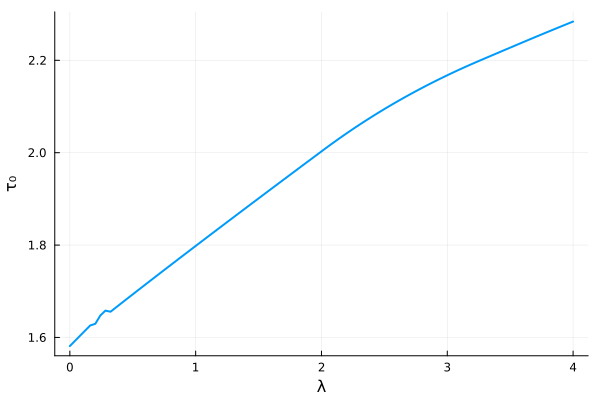

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda_mult_N2_fullprob_plot.png"

In [864]:
λ_vals = range(0.0, stop=4.0, length=100)
λ_vals_to_plot=[]
N=2
τ_0_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "tol", 1e-9)
    set_optimizer_attribute(model, "print_level", 0)
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    @variable(model, 0<=P_[1:np] <= 1) 
    @variable(model, τ[1:ni]) 
    @objective(model, Min, τ[1])
    @constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model))
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i],2.0)   # Initial guess for τ
    end    
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    # println(termination_status(model)==MOI.LOCALLY_SOLVED)
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, tau_opt[1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda_mult_N2_fullprob_plot.png")

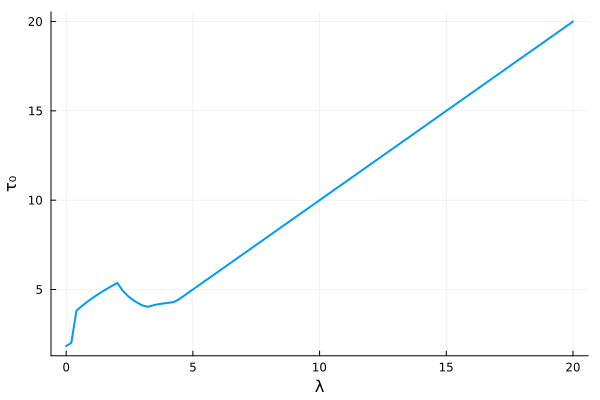

In [1096]:
λ_vals = range(0.0, stop=20.0, length=100)
λ_vals_to_plot=[]
N=2
τ_max_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "tol", 1e-9)
    set_optimizer_attribute(model, "print_level", 0)
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    @variable(model, 0<=P_[1:np] <= 1) 
    @variable(model, τ[1:ni]) 
    @objective(model, Min, τ[1])
    @constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model))
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i],0.0)   # Initial guess for τ
    end    
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    # println(termination_status(model)==MOI.LOCALLY_SOLVED)
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_max_values, maximum(tau_opt))
        # println(maximum(tau_opt))
    end
end
display(plot(λ_vals_to_plot, τ_max_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
# savefig("lambda_mult_N2_fullprob_plot.png")

For $N=3$

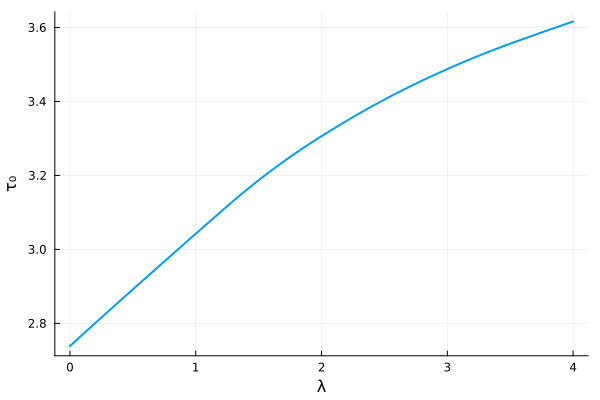

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda_mult_N3_fullprob_plot.png"

In [865]:
λ_vals = range(0.0, stop=4.0, length=100)
λ_vals_to_plot=[]
N=3
τ_0_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "tol", 1e-10)
    set_optimizer_attribute(model, "print_level", 0)
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    @variable(model, 0<=P_[1:np] <= 1) 
    @variable(model, τ[1:ni]) 
    @objective(model, Min, τ[1])
    @constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model))
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i],1.0)   # Initial guess for τ
    end    
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    # println(termination_status(model)==MOI.LOCALLY_SOLVED)
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, tau_opt[1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda_mult_N3_fullprob_plot.png")

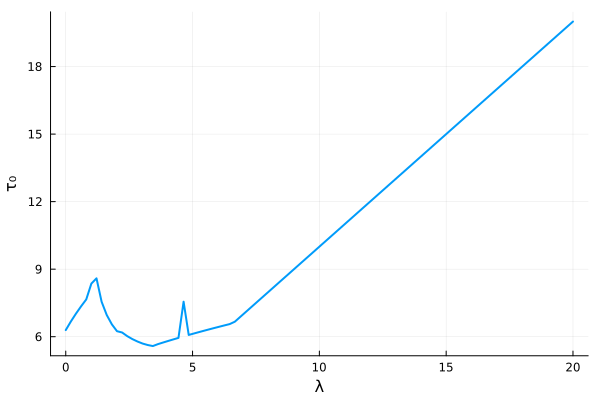

In [1097]:
λ_vals = range(0.0, stop=20.0, length=100)
λ_vals_to_plot=[]
N=3
τ_max_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "tol", 1e-9)
    set_optimizer_attribute(model, "print_level", 0)
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    @variable(model, 0<=P_[1:np] <= 1) 
    @variable(model, τ[1:ni]) 
    @objective(model, Min, τ[1])
    @constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model))
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i],0.0)   # Initial guess for τ
    end    
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    # println(termination_status(model)==MOI.LOCALLY_SOLVED)
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_max_values, maximum(tau_opt))
        # println(maximum(tau_opt))
    end
end
display(plot(λ_vals_to_plot, τ_max_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
# savefig("lambda_mult_N2_fullprob_plot.png")

For $N=4$

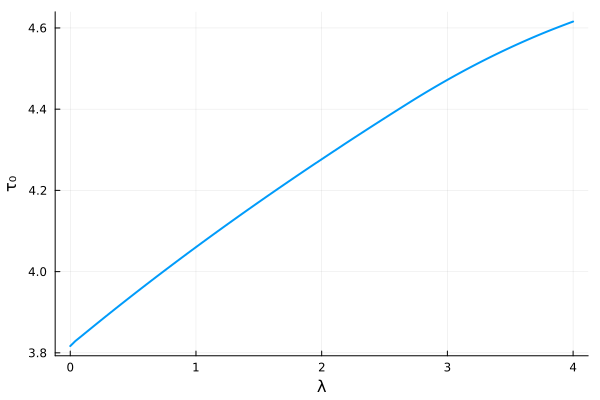

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda_mult_N4_fullprob_plot.png"

In [866]:
λ_vals = range(0.0, stop=4.0, length=100)
λ_vals_to_plot=[]
N=4
τ_0_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "tol", 1e-12)
    set_optimizer_attribute(model, "print_level", 0)
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    @variable(model, 0<=P_[1:np] <= 1) 
    @variable(model, τ[1:ni]) 
    @objective(model, Min, τ[1])
    @constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model))
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i],1.0)   # Initial guess for τ
    end    
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    # println(termination_status(model)==MOI.LOCALLY_SOLVED)
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, tau_opt[1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda_mult_N4_fullprob_plot.png")

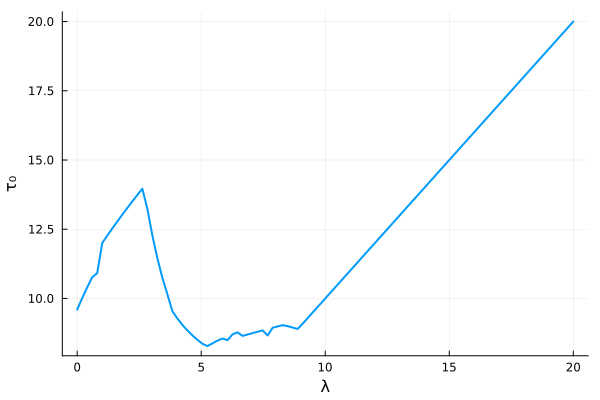

In [1098]:
λ_vals = range(0.0, stop=20.0, length=100)
λ_vals_to_plot=[]
N=4
τ_max_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "tol", 1e-9)
    set_optimizer_attribute(model, "print_level", 0)
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    @variable(model, 0<=P_[1:np] <= 1) 
    @variable(model, τ[1:ni]) 
    @objective(model, Min, τ[1])
    @constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model))
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i],0.0)   # Initial guess for τ
    end    
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    # println(termination_status(model)==MOI.LOCALLY_SOLVED)
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_max_values, maximum(tau_opt))
        # println(maximum(tau_opt))
    end
end
display(plot(λ_vals_to_plot, τ_max_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
# savefig("lambda_mult_N2_fullprob_plot.png")

For $N=5$

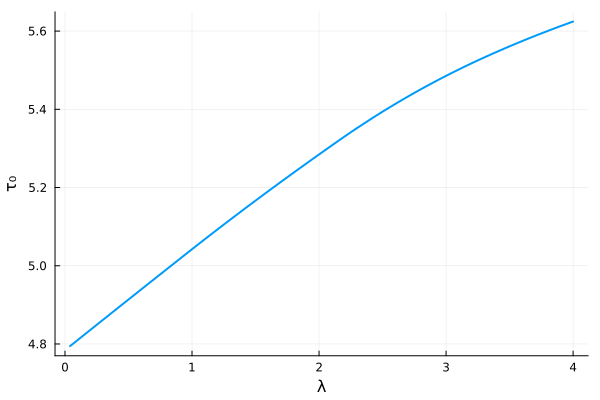

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda_mult_N5_fullprob_plot.png"

In [869]:
λ_vals = range(0.0, stop=4.0, length=100)
λ_vals_to_plot=[]
N=5
τ_0_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "tol", 1e-9)
    set_optimizer_attribute(model, "print_level", 0)
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    @variable(model, 0<=P_[1:np] <= 1) 
    @variable(model, τ[1:ni]) 
    @objective(model, Min, τ[1])
    @constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model))
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i],0.5)   # Initial guess for τ
    end    
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    # println(termination_status(model)==MOI.LOCALLY_SOLVED)
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, tau_opt[1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda_mult_N5_fullprob_plot.png")

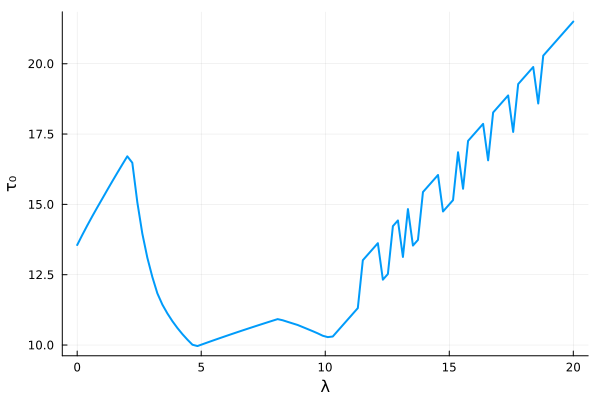

In [1099]:
λ_vals = range(0.0, stop=20.0, length=100)
λ_vals_to_plot=[]
N=5
τ_max_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "tol", 1e-9)
    set_optimizer_attribute(model, "print_level", 0)
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    @variable(model, 0<=P_[1:np] <= 1) 
    @variable(model, τ[1:ni]) 
    @objective(model, Min, τ[1])
    @constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model))
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i],0.0)   # Initial guess for τ
    end    
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    # println(termination_status(model)==MOI.LOCALLY_SOLVED)
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_max_values, maximum(tau_opt))
        # println(maximum(tau_opt))
    end
end
display(plot(λ_vals_to_plot, τ_max_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
# savefig("lambda_mult_N2_fullprob_plot.png")

For $N=6$

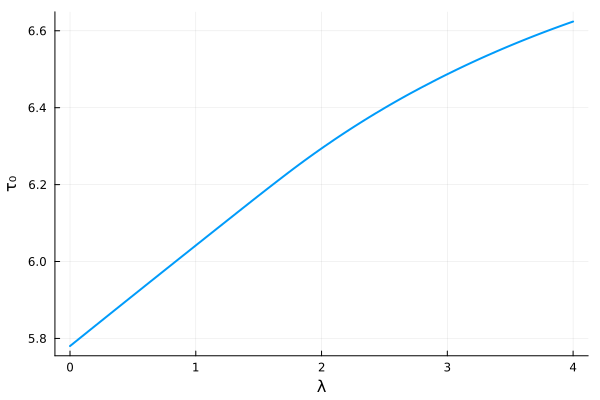

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda_mult_N6_fullprob_plot.png"

In [868]:
λ_vals = range(0.0, stop=4.0, length=100)
λ_vals_to_plot=[]
N=6
τ_0_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "tol", 1e-9)
    set_optimizer_attribute(model, "print_level", 0)
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    @variable(model, 0<=P_[1:np] <= 1) 
    @variable(model, τ[1:ni]) 
    @objective(model, Min, τ[1])
    @constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model))
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i],0.0)   # Initial guess for τ
    end    
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    # println(termination_status(model)==MOI.LOCALLY_SOLVED)
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, tau_opt[1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda_mult_N6_fullprob_plot.png")

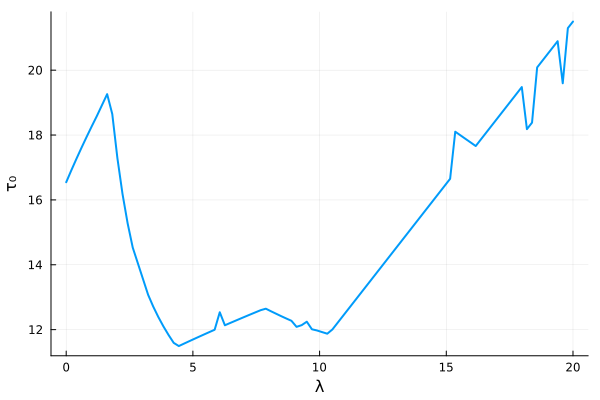

In [1100]:
λ_vals = range(0.0, stop=20.0, length=100)
λ_vals_to_plot=[]
N=6
τ_max_values = []
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "tol", 1e-9)
    set_optimizer_attribute(model, "print_level", 0)
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    @variable(model, 0<=P_[1:np] <= 1) 
    @variable(model, τ[1:ni]) 
    @objective(model, Min, τ[1])
    @constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ_,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ_,model))
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i],0.0)   # Initial guess for τ
    end    
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    # println(termination_status(model)==MOI.LOCALLY_SOLVED)
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_max_values, maximum(tau_opt))
        # println(maximum(tau_opt))
    end
end
display(plot(λ_vals_to_plot, τ_max_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
# savefig("lambda_mult_N2_fullprob_plot.png")

### Doing so using our matrix formulation?

In [870]:
function M_maker_mod(N::Int64,λ::Float64, model,S,Skeyer)
    ni,np,ns,nt=varioussizes(N)
    M=@expression(model, zeros(AffExpr, ni, ni, np)) 
    for (u, u_) in Iterators.product(values(S), values(S))
        # Skip if u and u_ are the same
        if u == u_
            continue
        end

        i = Skeyer[u]
        j = Skeyer[u_]
        flag = 0
        ua, ub, sa, sb = u
        ua_, ub_, sa_, sb_ = u_

        tempk = 0

        if ua_==ua+1 && ub == ub_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = N * sa + ua + 1
        elseif ua_==ua-1 && ub == ub_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = sa * N + ua + 2 * N 
        elseif ub_==ub+1 && ua == ua_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = N * sb + ub + 1
        elseif ub_==ub-1 && ua == ua_ && sa == sa_ && sb == sb_
            flag = 1
            tempk = sb * N + ub + 2 * N 
        elseif ua == ua_ && ub == ub_ && sb == sb_ && sa==0 && sa_==1
            flag = 1
            tempk = 4 * N + ub + 1
        elseif ua == ua_ && ub == ub_ && sb == sb_ && sa==1 && sa_==0
            flag = 1
            tempk = 5 * N + 2
        elseif ua == ua_ && ub == ub_ && sa == sa_ && sb==0 && sb_==1
            flag = 1
            tempk = 4 * N + ua + 1
        elseif ua == ua_ && ub == ub_ && sa == sa_ && sb==1 && sb_==0
            flag = 1
            tempk = 5 * N + 2
        end

        if flag == 1
            M[i+1, j+1, tempk] = flag
        end
    end
    for k in 1:np
        # Calculate the sum of each row for the kth slice of M (equivalent to M[:,:,k] in Python)
        M_i = [sum(M[:, :, k][i, :]) for i in 1:ni]

        for u in values(S)
            i = Skeyer[u]
            M[i+1, i+1, k] = -M_i[i+1]
        end
    end
    
    return M
end

M_maker_mod (generic function with 1 method)

In [871]:
function Q_maker_using_M_mod(P,N::Int64,λ::Float64,model,S,Skeyer)
    ni,np,ns,nt=varioussizes(N)
    M=M_maker_mod(N,λ,model,S,Skeyer)
    Q = reduce((x, y) -> x + y, [P[k] * M[:, :, k] for k in 1:np])
    return Q
end

Q_maker_using_M_mod (generic function with 1 method)

Next, we construct a restricted $\widetilde{M}$ and $\widetilde{Q}$


In [872]:
function Q_maker_tilde_mod(P,N::Int64,λ::Float64, model,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)

    #Get Q
    Q=Q_maker_original_mod(P,N,λ, model,S,Skeyer)

    #Get Restricter R

    R = zeros(ns, ni)
    for i in 1:ns
        R[i,Tc[i]+1] = 1
    end

    Qtilde = R * Q * R'
    return Qtilde
end

Q_maker_tilde_mod (generic function with 1 method)

In [873]:
function M_maker_tilde(N::Int64,λ::Float64,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)

    #Get M
    M=M_maker(N,λ,S,Skeyer)
    #Get Restricter R

    R = zeros(ns, ni)
    for i in 1:ns
        R[i,Tc[i]+1] = 1
    end
    
    Mtilde=zeros(ns, ns, np)
    for k in 1:np
        Mtilde[:, :, k] = R * M[:, :, k] * R'
    end

    return Mtilde
end

M_maker_tilde (generic function with 1 method)

In [874]:
function M_maker_tilde_mod(N::Int64,λ::Float64, model,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)

    #Get M
    M=M_maker_mod(N,λ,model,S,Skeyer)

    #Get Restricter R

    R = zeros(ns, ni)
    for i in 1:ns
        R[i,Tc[i]+1] = 1
    end
    Mtilde=@expression(model, zeros(AffExpr, ns, ns, np)) 
    for k in 1:np
        Mtilde[:, :, k] = R * M[:, :, k] * R'
    end

    return Mtilde
end

M_maker_tilde_mod (generic function with 1 method)

In [875]:
function Q_maker_tilde_2_mod(P,N::Int64,λ::Float64, model,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    Mtilde=M_maker_tilde_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
    return reduce((x, y) -> x + y, [P[k] * Mtilde[:, :, k] for k in 1:np])
end

Q_maker_tilde_2_mod (generic function with 1 method)

In [876]:
function A_maker(N::Int64,λ::Float64,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    Mtilde=M_maker_tilde(N,λ,S,Skeyer,T,TG,TB,Tc)
    Ai = zeros(ns, np, ns)
    for i in 1:ns
        Ai[:,:,i]= Mtilde[i,:,:]   
    end
    return Ai
end

A_maker (generic function with 1 method)

In [877]:
function A_maker_mod(N::Int64,λ::Float64, model,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    Mtilde=M_maker_tilde_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
    Ai = @expression(model, zeros(AffExpr, ns, np, ns)) 
    for i in 1:ns
        Ai[:,:,i]= Mtilde[i,:,:]   
    end
    return Ai
end

A_maker_mod (generic function with 1 method)

In [878]:
function alpha_maker(N::Int64,λ::Float64,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    alpha=zeros(np, ns)
    M=M_maker(N,λ,S,Skeyer)
    for i in 1:ns
        Si=Tc[i]
        for j in 1:ni
            for k in 1:np
                if (j-1 ∈ TB)
                    # println(i," ",Si," ",j," ",k," ", size(M), " ", size(alpha)," ", M[Si+1,j,k])
                    alpha[k,i]+=M[Si+1,j,k]
                end
                
            end
        end
    end
    return alpha
end

alpha_maker (generic function with 1 method)

In [879]:
function alpha_maker_mod(N::Int64,λ::Float64, model,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    alpha=@expression(model, zeros(AffExpr, np, ns))
    M=M_maker_mod(N,λ,model,S,Skeyer)
    for i in 1:ns
        Si=Tc[i]
        for j in 1:ni
            for k in 1:np
                if (j-1 ∈ TB)
                    # println(i," ",Si," ",j," ",k," ", size(M), " ", size(alpha)," ", M[Si+1,j,k])
                    alpha[k,i]+=M[Si+1,j,k]
                end
                
            end
        end
    end
    return alpha
end

alpha_maker_mod (generic function with 1 method)

In [880]:
N=3
model = Model(Ipopt.Optimizer)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
f⁺=rand(N, 2)
f⁻=rand(N, 2)
f⁺_flattened = collect(Iterators.flatten(f⁺'))
f⁻_flattened = collect(Iterators.flatten(f⁻'))
g=rand(N+1)
koff=rand(Uniform(0,1))
P = collect(vcat(f⁺_flattened, f⁻_flattened, g, [koff]))
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Q=Q_maker_original_mod(P,N,λ,model,S,Skeyer)
Q_exact=Q_maker(P,N,λ,S,Skeyer)
Q2=Q_maker_using_M_mod(P,N,λ,model,S,Skeyer)

# println(maximum(abs.(Qtilde2-Qtilde)))

τ_actual=hitting_time(Q_exact,targetstates_good,targetstates_bad,allstates,λ)
τ_now=hitting_time_mod(Q2,targetstates_good,targetstates_bad,allstates,λ,model)
println("maximum error: ",maximum(abs.(τ_actual-τ_now)))
println("τ_0,exact: ",τ_actual[1])
println("τ_0: ",τ_now[1])

maximum error: 4.440892098500626e-15
τ_0,exact: 7.241053860136411
τ_0: 7.241053860136407


In [881]:
model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "print_level", 0)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Q=Q_maker_original_mod(P,N,λ,model,S,Skeyer)
Q_exact=Q_maker(P,N,λ,S,Skeyer)

alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)

# Qtilde=Q_maker_tilde_mod(P,N,λ,model,S,Skeyer,T,TG,TB,Tc)
# Qtilde2=Q_maker_tilde_2_mod(P,N,λ,model,S,Skeyer,T,TG,TB,Tc)
# Mtilde=M_maker_tilde_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)

n=size(Q,1)
@variable(model, τ[1:ns])
for i=1:ns
    @constraint(model, 1 + τ'*Ai[:,:,i]*P + λ*alpha[:,i]'*P == 0)
end
optimize!(model)
τ_now=value.(τ)
println("τ_0: ",τ_now[1])

τ_0: 7.241053860136408


In [882]:
model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "print_level", 0)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Q=Q_maker_original_mod(P,N,λ,model,S,Skeyer)
Q_exact=Q_maker(P,N,λ,S,Skeyer)

alpha=alpha_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
Ai=A_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)

Qtilde=Q_maker_tilde_mod(P,N,λ,model,S,Skeyer,T,TG,TB,Tc)
Qtilde2=Q_maker_tilde_2_mod(P,N,λ,model,S,Skeyer,T,TG,TB,Tc)
Mtilde=M_maker_tilde_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)

n=size(Q,1)
@variable(model, τ[1:ns])
for i=1:ns
    @constraint(model, 1 + τ'*Ai[:,:,i]*P + λ*alpha[:,i]'*P == 0)
end
optimize!(model)
τ_now=value.(τ)
println("τ_0: ",τ_now[1])

τ_0: 7.241053860136408


So for given $P$, the matrix formulation does give the correct optimised function!

In [885]:
N=5
λ=0.5
model = Model(Ipopt.Optimizer)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
set_optimizer_attribute(model, "tol", 1e-8)
set_optimizer_attribute(model, "print_level", 0)
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

@variable(model, 0<=P_[1:np] <= 1) 
@variable(model, τ[1:ni]) 
@NLobjective(model, Min, τ[1])
@constraint(model, hitting_time_mod_give_A(Q_maker_original_mod(P_,N,λ,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ,model) * τ == hitting_time_mod_give_b(Q_maker_original_mod(P_,N,λ,model,S,Skeyer),targetstates_good,targetstates_bad,allstates,λ,model))
for i in 1:np
    set_start_value(P_[i], 1.0)  # Initial guess for P_
end

for i in 1:ns
    set_start_value(τ[i], 1.0)   # Initial guess for τ
end
optimize!(model)
P_opt=value.(P_);
tau_opt=value.(τ);
tau_opt[1]

4.913710235184018

In [886]:
N=5
λ=0.5

model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "tol", 1e-8)
set_optimizer_attribute(model, "print_level", 0)
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]
alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
@variable(model, 1>=P_[1:np]>=0) 
@variable(model, τ[1:ns])
@objective(model, Min, τ[1])
for i=1:ns
    @constraint(model, τ'*Ai[:,:,i]*P_ + λ*alpha[:,i]'*P_ == -1)
end
for i in 1:np
    set_start_value(P_[i], 0.5)  # Initial guess for P_
end

for i in 1:ns
    set_start_value(τ[i], N/2)   # Initial guess for τ
end
optimize!(model)
P_opt=value.(P_);
tau_opt=value.(τ);
println(tau_opt[1])

4.9137102352124735


For values of $\lambda$ and $N$ where this and earlier method, both, are feasible, the optimal soln is same

$N=2$

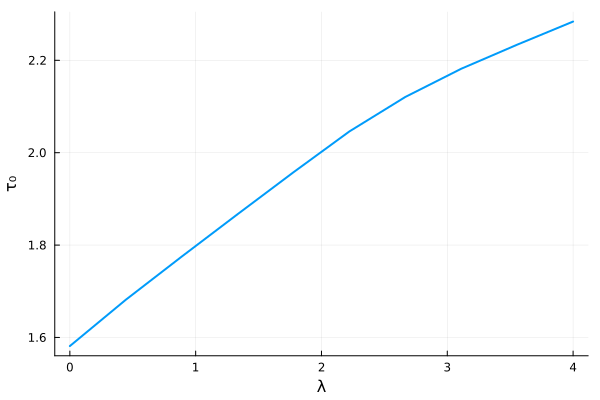

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda_mult_N2_fullprob_mat_form_plot.png"

In [892]:
λ_vals = range(0.0, stop=4.0, length=10)
N=2
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
τ_0_values = []
λ_vals_to_plot=[]
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "tol", 1e-9)
    set_optimizer_attribute(model, "print_level", 0)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    @variable(model, 1>=P_[1:np]>=0) 
    @variable(model, τ[1:ns])
    @objective(model, Min, τ[1])
    for i=1:ns
        @constraint(model, 1 + τ'*Ai[:,:,i]*P_ + λ_*alpha[:,i]'*P_ == 0)
    end
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i], 1.0)   # Initial guess for τ
    end
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, tau_opt[1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda_mult_N2_fullprob_mat_form_plot.png")

$N=3$

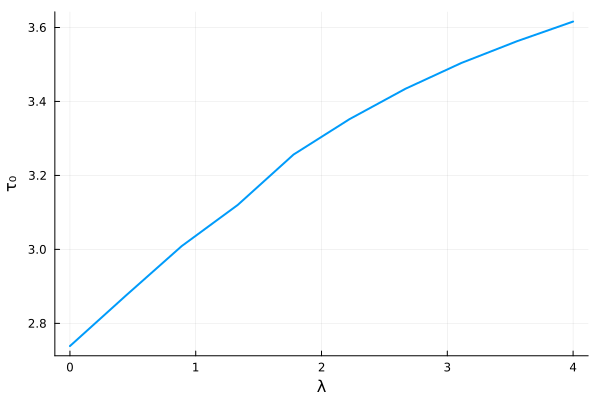

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda_mult_N3_fullprob_mat_form_plot.png"

In [904]:
λ_vals = range(0.0, stop=4.0, length=10)
N=3
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
τ_0_values = []
λ_vals_to_plot=[]
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "tol", 1e-9)
    set_optimizer_attribute(model, "print_level", 0)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    @variable(model, 1>=P_[1:np]>=0) 
    @variable(model, τ[1:ns])
    @objective(model, Min, τ[1])
    for i=1:ns
        @constraint(model, 1 + τ'*Ai[:,:,i]*P_ + λ_*alpha[:,i]'*P_ == 0)
    end
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i], 1.0)   # Initial guess for τ
    end
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, tau_opt[1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda_mult_N3_fullprob_mat_form_plot.png")

In [898]:
# λ_vals = range(0.0, stop=1.0, length=10)
# N=3
# S,Skeyer,T,TG,TB,Tc=statematrices(N);
# ni,np,ns,nt=varioussizes(N)
# τ_0_values = []
# for λ_ in λ_vals
#     model = Model(Ipopt.Optimizer)
#     set_optimizer_attribute(model, "print_level", 0)
#     targetstates_good=[target_state+1 for target_state ∈ TG];
#     targetstates_bad=[target_state+1 for target_state ∈ TB];
#     targetstates=[targetstates_good;targetstates_bad]
#     startstates=[start_state+1 for start_state ∈ Tc];
#     allstates=[startstates;targetstates_good; targetstates_bad]
#     alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
#     Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
#     @variable(model, 1>=P_[1:np]>=0) 
#     @variable(model, τ[1:ns])
#     @objective(model, Min, τ[1])
#     for i=1:ns
#         @constraint(model, 1 + τ'*Ai[:,:,i]*P_ + λ_*alpha[:,i]'*P_ == 0)
#     end
#     for i in 1:np
#         set_start_value(P_[i], 1.0)  # Initial guess for P_
#     end
    
#     for i in 1:ns
#         set_start_value(τ[i], 1.0)   # Initial guess for τ
#     end
#     optimize!(model)
#     P_opt=value.(P_);
#     tau_opt=value.(τ);
#     push!(τ_0_values, tau_opt[1])
# end
# plot(λ_vals, τ_0_values, label="τ_0", xlabel="λ", ylabel="τ_0", title="Hitting Time Starting at 0 for a fixed set of paramter values", lw=2)




$N=4$

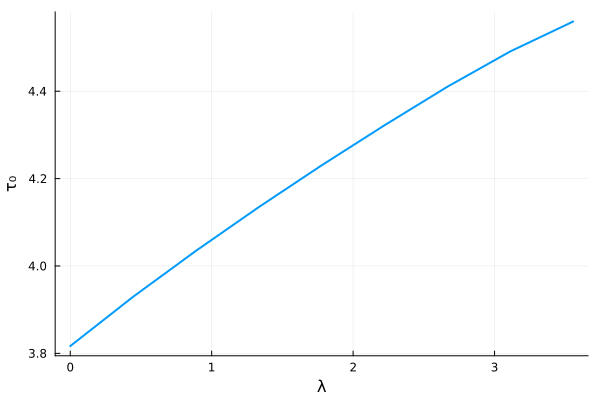

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda_mult_N4_fullprob_mat_form_plot.png"

In [901]:
λ_vals = range(0.0, stop=4.0, length=10)
N=4
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
τ_0_values = []
λ_vals_to_plot=[]
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "tol", 1e-9)
    set_optimizer_attribute(model, "print_level", 0)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    @variable(model, 1>=P_[1:np]>=0) 
    @variable(model, τ[1:ns])
    @objective(model, Min, τ[1])
    for i=1:ns
        @constraint(model, 1 + τ'*Ai[:,:,i]*P_ + λ_*alpha[:,i]'*P_ == 0)
    end
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i], 0.5)   # Initial guess for τ
    end
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, tau_opt[1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda_mult_N4_fullprob_mat_form_plot.png")

$N=5$

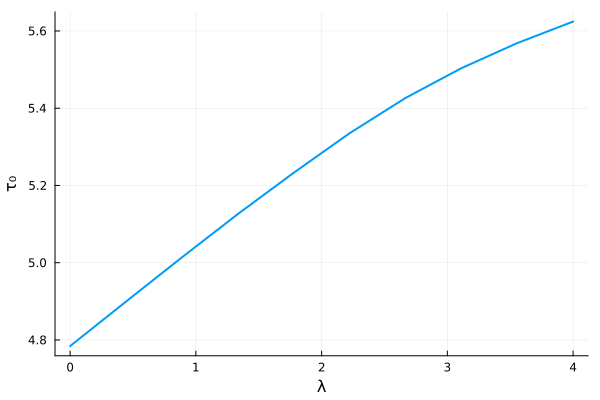

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda_mult_N5_fullprob_mat_form_plot.png"

In [903]:
λ_vals = range(0.0, stop=4.0, length=10)
N=5
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
τ_0_values = []
λ_vals_to_plot=[]
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "tol", 1e-9)
    set_optimizer_attribute(model, "print_level", 0)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    @variable(model, 1>=P_[1:np]>=0) 
    @variable(model, τ[1:ns])
    @objective(model, Min, τ[1])
    for i=1:ns
        @constraint(model, 1 + τ'*Ai[:,:,i]*P_ + λ_*alpha[:,i]'*P_ == 0)
    end
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i], 0.5)   # Initial guess for τ
    end
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, tau_opt[1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda_mult_N5_fullprob_mat_form_plot.png")

$N=6$

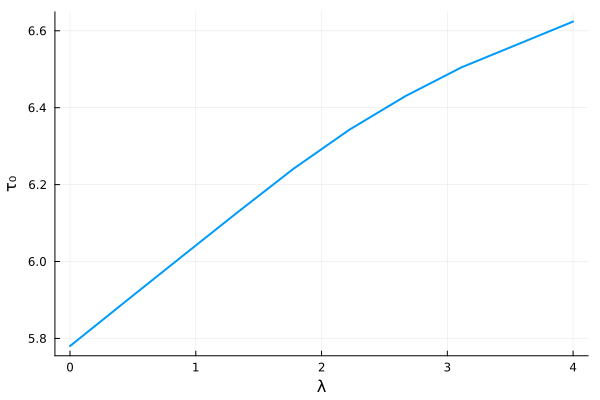

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda_mult_N6_fullprob_mat_form_plot.png"

In [906]:
λ_vals = range(0.0, stop=4.0, length=10)
N=6
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
τ_0_values = []
λ_vals_to_plot=[]
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "tol", 1e-9)
    set_optimizer_attribute(model, "print_level", 0)
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    @variable(model, 1>=P_[1:np]>=0) 
    @variable(model, τ[1:ns])
    @objective(model, Min, τ[1])
    for i=1:ns
        @constraint(model, 1 + τ'*Ai[:,:,i]*P_ + λ_*alpha[:,i]'*P_ == 0)
    end
    for i in 1:np
        set_start_value(P_[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(τ[i], 0.5)   # Initial guess for τ
    end
    optimize!(model)
    P_opt=value.(P_);
    tau_opt=value.(τ);
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, tau_opt[1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda_mult_N6_fullprob_mat_form_plot.png")

The above graph is wonky due to convergence to infeasible solution

# Solving the matrix formulation of the problem (QCQP)

We begin by noting the various functons to get the matrices in the problem

In [908]:
function D_maker(N::Int64,λ::Float64,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    Di=zeros(nt, nt, ns)

    alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    
    for i in 1:ns
        Di[np+1:np+ns,1:np,i]=Ai[:,:,i]
        Di[1:np,nt,i]=λ*alpha[:,i]'
        Di[nt,nt,i]=1
    end
    D_i=copy(Di)
    for i in 1:ns
        D_i[ :, :,i] = (Di[ :, :,i] + Di[ :, :,i]') / 2
    end
    return D_i
end

D_maker (generic function with 1 method)

In [909]:
function D_maker_mod(N::Int64,λ::Float64, model,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    Di=@expression(model, zeros(AffExpr, nt, nt, ns))

    Ai=A_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
    alpha=alpha_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
    
    for i in 1:ns
        Di[np+1:np+ns,1:np,i]=Ai[:,:,i]
        Di[1:np,nt,i]=λ*alpha[:,i]'
        Di[nt,nt,i]=1
    end
    D_i=copy(Di)
    for i in 1:ns
        D_i[ :, :,i] = (Di[ :, :,i] + Di[ :, :,i]') / 2
    end
    return D_i
end

D_maker_mod (generic function with 1 method)

In [910]:
function E_maker(N::Int64,λ::Float64,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    Ei=zeros(nt, nt, nt)

    alpha=alpha_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    Ai=A_maker(N,λ,S,Skeyer,T,TG,TB,Tc)
    
    for i in 1:nt
        Ei[i,nt,i]=1
    end
    
    E_i=copy(Ei)
    
    for i in 1:nt
        E_i[ :, :,i] = (Ei[ :, :,i] + Ei[ :, :,i]') / 2
    end
    return E_i
end

E_maker (generic function with 1 method)

In [911]:
function E_maker_mod(N::Int64,λ::Float64, model,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    Ei=@expression(model, zeros(AffExpr, nt, nt, nt))

    Ai=A_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
    alpha=alpha_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
    
    for i in 1:nt
        Ei[i,nt,i]=1
    end
    
    E_i=copy(Ei)
    
    for i in 1:nt
        E_i[ :, :,i] = (Ei[ :, :,i] + Ei[ :, :,i]') / 2
    end
    return E_i
end

E_maker_mod (generic function with 1 method)

In [912]:
function C_maker(N::Int64,λ::Float64,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    C_i=zeros(nt, nt, np)
    
    for i in 1:np
        C_i[i,i,i]=1
    end
    return C_i
end

C_maker (generic function with 1 method)

In [913]:
function C_maker_mod(N::Int64,λ::Float64, model,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    C_i=@expression(model, zeros(AffExpr, nt, nt, np))
    
    for i in 1:np
        C_i[i,i,i]=1
    end
    return C_i
end

C_maker_mod (generic function with 1 method)

In [914]:
function F_maker(N::Int64,λ::Float64,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    Fij=zeros(nt, nt, np, np)
    for i in 1:np
        for j in 1:np
            Fij[i,j,i,j]=1
        end
    end
    Fiji=copy(Fij)
    for i in 1:np
        for j in 1:np
            Fiji[ :, :,i,j] = (Fij[ :, :,i,j] + Fij[ :, :,i,j]') / 2
        end
    end
    print(size(Fiji))
    return Fiji
end

F_maker (generic function with 1 method)

In [ ]:
function F_maker(N::Int64,λ::Float64,S,Skeyer,T,TG,TB,Tc)
    ni,np,ns,nt=varioussizes(N)
    Fij=zeros(nt, nt, np, np)
    for i in 1:np
        for j in 1:np
            Fij[i,j,i,j]=1
        end
    end
    Fiji=copy(Fij)
    for i in 1:np
        for j in 1:np
            Fiji[ :, :,i,j] = (Fij[ :, :,i,j] + Fij[ :, :,i,j]') / 2
        end
    end
    print(size(Fiji))
    return Fiji
end

## Non-Linearly

In [916]:
N=5
λ=1.0

model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "tol", 1e-8)
set_optimizer_attribute(model, "print_level", 0)

S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)

targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Ai=A_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
alpha=alpha_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)

@variable(model, 1>=P_[1:np]>=0) 
@variable(model, τ[1:ns])
@objective(model, Min, τ[1])
for i=1:ns
    @constraint(model, τ'*Ai[:,:,i]*P_ + λ*alpha[:,i]'*P_ == -1)
end
for i in 1:np
    set_start_value(P_[i], 1.0)  
end

for i in 1:ns
    set_start_value(τ[i], N/2)   
end
optimize!(model)
P_opt=value.(P_);
tau_opt=value.(τ);
println(tau_opt[1])

5.042298236196925


In [1000]:
N=3
λ=1.0

model = Model(Ipopt.Optimizer)
# set_optimizer_attribute(model, "tol", 1e-8)
set_optimizer_attribute(model, "print_level", 0)

S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)

targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Di=D_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
Ei=E_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
S0=Ei[:,:,np+1];
Ci=C_maker(N,λ,S,Skeyer,T,TG,TB,Tc);

# println(size(Ci))

@variable(model, Z[1:nt]>=0)
@objective(model, Min, Z' * S0 * Z)

for i=1:np
    @constraint(model, Z' * Ci[:,:,i] * Z <=1.0)
end
for i=1:ns
    @constraint(model, Z' * Di[:,:,i] * Z == 0.0)
end
for i=1:nt
    @constraint(model, Z' * Ei[:,:,i] * Z >= 0)
end
@constraint(model, Z' * Ei[:,:,end] * Z == 1)
optimize!(model)
solution = value.(Z);
println(solution' * S0 * solution)
println(solution[np+1])

3.0601998275464237
3.0601998275464237


$N=2$

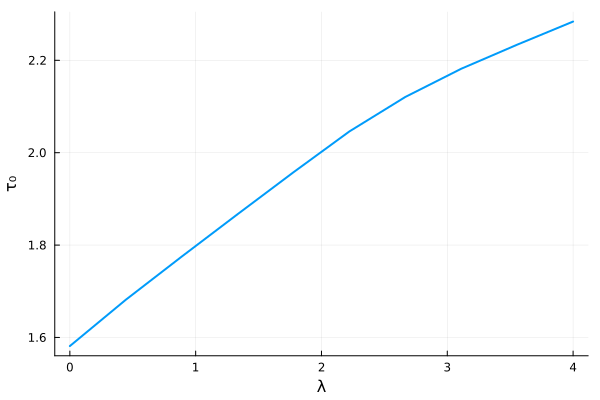

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda_mult_N2_fullprob_qcqp_form_plot.png"

In [926]:
λ_vals = range(0.0, stop=4.0, length=10)
N=2
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
τ_0_values = []
λ_vals_to_plot=[]
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    set_optimizer_attribute(model, "tol", 1e-9)
    
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    
    Di=D_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    Ei=E_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    S0=Ei[:,:,np+1];
    Ci=C_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    
    # println(size(Ci))
    
    @variable(model, Z[1:nt]>=0)
    @objective(model, Min, Z' * S0 * Z)
    
    for i=1:np
        @constraint(model, Z' * Ci[:,:,i] * Z <=1.0)
    end
    for i=1:ns
        @constraint(model, Z' * Di[:,:,i] * Z == 0.0)
    end
    for i=1:nt
        @constraint(model, Z' * Ei[:,:,i] * Z >= 0)
    end
    @constraint(model, Z' * Ei[:,:,end] * Z == 1)
    for i in 1:np
        set_start_value(Z[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(Z[np+i], 2.0)   # Initial guess for τ
    end
    set_start_value(Z[nt], 1)
    optimize!(model)
    solution = value.(Z);
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, solution[np+1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda_mult_N2_fullprob_qcqp_form_plot.png")

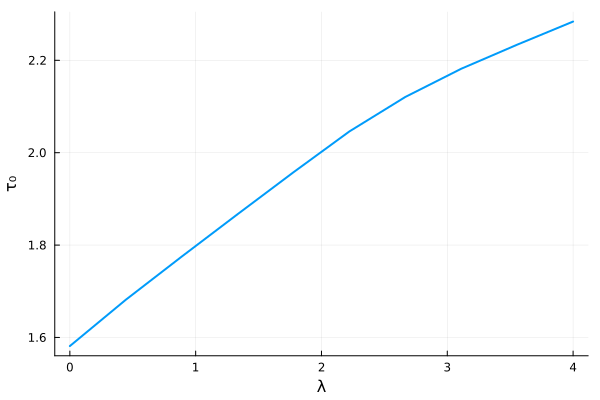

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda_mult_N2_fullprob_qcqp_form_plot.png"

In [1011]:
λ_vals = range(0.0, stop=4.0, length=10)
N=2
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
τ_0_values = []
λ_vals_to_plot=[]
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    set_optimizer_attribute(model, "tol", 1e-9)
    
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    
    Di=D_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    Ei=E_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    S0=Ei[:,:,np+1];
    Ci=C_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    
    # println(size(Ci))
    
    @variable(model, Z[1:nt]>=0)
    @objective(model, Min, Z' * S0 * Z)
    
    for i=1:np
        @constraint(model, Z' * Ci[:,:,i] * Z <=1.0)
    end
    for i=1:ns
        @constraint(model, Z' * Di[:,:,i] * Z == 0.0)
    end
    # for i=1:nt
    #     @constraint(model, Z' * Ei[:,:,i] * Z >= 0)
    # end
    @constraint(model, Z.>= 0)
    @constraint(model, Z' * Ei[:,:,end] * Z == 1)
    for i in 1:np
        set_start_value(Z[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(Z[np+i], 2.0)   # Initial guess for τ
    end
    set_start_value(Z[nt], 1)
    optimize!(model)
    solution = value.(Z);
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, solution[np+1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda_mult_N2_fullprob_qcqp_form_plot.png")

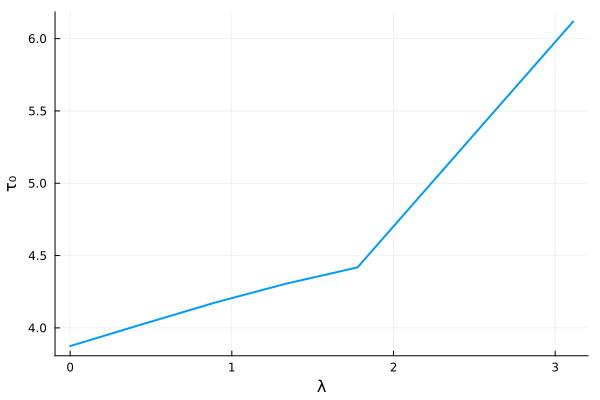

In [1024]:
λ_vals = range(0.0, stop=4.0, length=10)
N=4
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
τ_0_values = []
λ_vals_to_plot=[]
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    set_optimizer_attribute(model, "tol", 1e-9)
    
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    
    Di=D_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    Ei=E_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    S0=Ei[:,:,np+1];
    Ci=C_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    
    # println(size(Ci))
    
    @variable(model, Z[1:nt]>=0)
    @objective(model, Min, Z' * S0 * Z)
    
    for i=1:np
        @constraint(model, Z' * Ci[:,:,i] * Z <=1.0)
    end
    for i=1:ns
        @constraint(model, Z' * Di[:,:,i] * Z == 0.0)
    end
    # for i=1:nt
    #     @constraint(model, Z' * Ei[:,:,i] * Z >= 0)
    # end
    @constraint(model, Z.>= 0)
    @constraint(model, Z' * Ei[:,:,end] * Z == 1)
    for i in 1:np
        set_start_value(Z[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(Z[np+i], 0.81)   # Initial guess for τ
    end
    set_start_value(Z[nt], 1)
    optimize!(model)
    solution = value.(Z);
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, solution[np+1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
# savefig("lambda_mult_N2_fullprob_qcqp_form_plot.png")

$N=3$

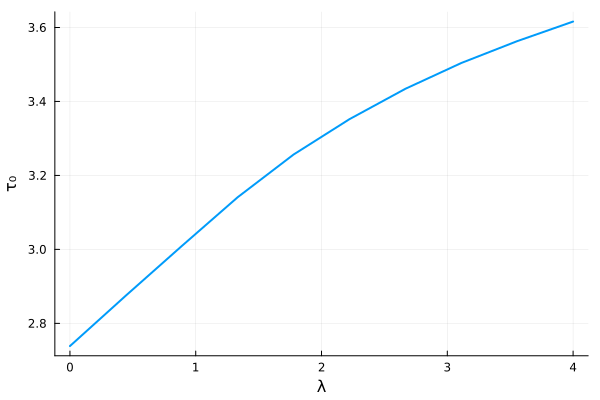

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda_mult_N3_fullprob_qcqp_form_plot.png"

In [924]:
λ_vals = range(0.0, stop=4.0, length=10)
N=3
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
τ_0_values = []
λ_vals_to_plot=[]
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    set_optimizer_attribute(model, "tol", 1e-9)
    
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    
    Di=D_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    Ei=E_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    S0=Ei[:,:,np+1];
    Ci=C_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    
    # println(size(Ci))
    
    @variable(model, Z[1:nt]>=0)
    @objective(model, Min, Z' * S0 * Z)
    
    for i=1:np
        @constraint(model, Z' * Ci[:,:,i] * Z <=1.0)
    end
    for i=1:ns
        @constraint(model, Z' * Di[:,:,i] * Z == 0.0)
    end
    for i=1:nt
        @constraint(model, Z' * Ei[:,:,i] * Z >= 0)
    end
    @constraint(model, Z' * Ei[:,:,end] * Z == 1)
    for i in 1:np
        set_start_value(Z[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(Z[np+i], 1.25)   # Initial guess for τ
    end
    set_start_value(Z[nt], 1)
    optimize!(model)
    solution = value.(Z);
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, solution[np+1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda_mult_N3_fullprob_qcqp_form_plot.png")

$N=4$

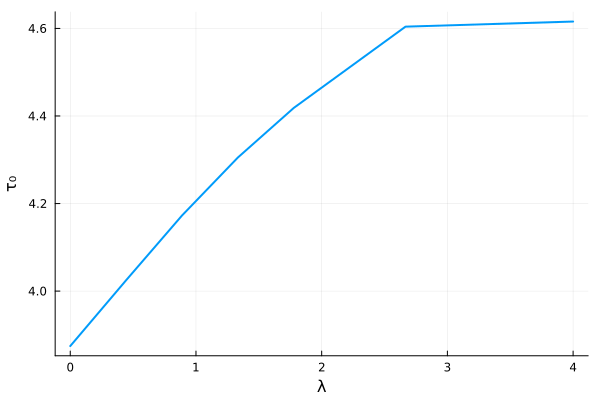

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda_mult_N4_fullprob_qcqp_form_plot.png"

In [963]:
λ_vals = range(0.0, stop=4.0, length=10)
N=4
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
τ_0_values = []
λ_vals_to_plot=[]
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    set_optimizer_attribute(model, "tol", 1e-9)
    
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    
    Di=D_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    Ei=E_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    S0=Ei[:,:,np+1];
    Ci=C_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);

    # println(size(Ci))
    
    @variable(model, Z[1:nt]>=0)
    @objective(model, Min, Z' * S0 * Z)
    
    for i=1:np
        @constraint(model, Z' * Ci[:,:,i] * Z <=1.0)
    end
    for i=1:ns
        @constraint(model, Z' * Di[:,:,i] * Z == 0.0)
    end
    for i=1:nt
        @constraint(model, Z' * Ei[:,:,i] * Z >= 0)
    end
    @constraint(model, Z' * Ei[:,:,end] * Z == 1)
    for i in 1:np
        set_start_value(Z[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(Z[np+i], 0.81)   # Initial guess for τ
    end
    set_start_value(Z[nt], 1)
    optimize!(model)
    solution = value.(Z);
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, solution[np+1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda_mult_N4_fullprob_qcqp_form_plot.png")

$N=5$

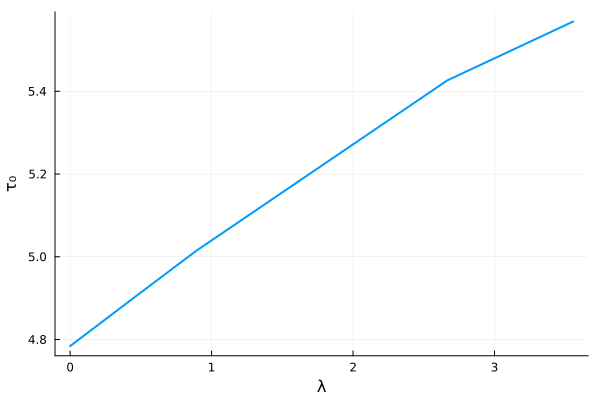

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda_mult_N5_fullprob_qcqp_form_plot.png"

In [945]:
λ_vals = range(0.0, stop=4.0, length=10)
N=5
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
τ_0_values = []
λ_vals_to_plot=[]
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    set_optimizer_attribute(model, "tol", 1e-9)
    
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    
    Di=D_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    Ei=E_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    S0=Ei[:,:,np+1];
    Ci=C_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    
    # println(size(Ci))
    
    @variable(model, Z[1:nt]>=0)
    @objective(model, Min, Z' * S0 * Z)
    
    for i=1:np
        @constraint(model, Z' * Ci[:,:,i] * Z <=1.0)
    end
    for i=1:ns
        @constraint(model, Z' * Di[:,:,i] * Z == 0.0)
    end
    for i=1:nt
        @constraint(model, Z' * Ei[:,:,i] * Z >= 0)
    end
    @constraint(model, Z' * Ei[:,:,end] * Z == 1)
    for i in 1:np
        set_start_value(Z[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(Z[np+i], 0.475)   # Initial guess for τ
    end
    set_start_value(Z[nt], 1)
    optimize!(model)
    solution = value.(Z);
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, solution[np+1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda_mult_N5_fullprob_qcqp_form_plot.png")

$N=6$

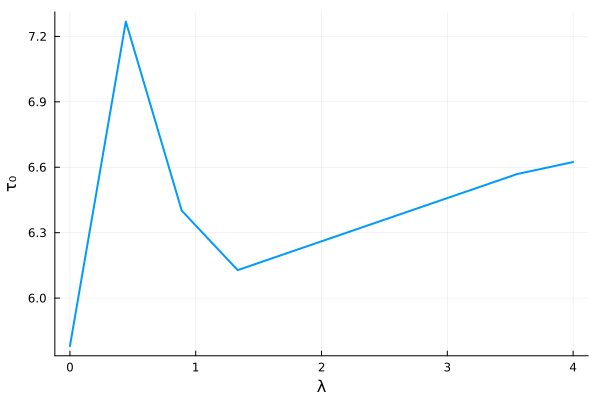

"/Users/ashutoshtripathi/Desktop/CellularDecisionMaking/Ashu/lambda_mult_N6_fullprob_qcqp_form_plot.png"

In [972]:
λ_vals = range(0.0, stop=4.0, length=10)
N=6
S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)
τ_0_values = []
λ_vals_to_plot=[]
for λ_ in λ_vals
    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    set_optimizer_attribute(model, "tol", 1e-9)
    
    S,Skeyer,T,TG,TB,Tc=statematrices(N);
    ni,np,ns,nt=varioussizes(N)
    
    targetstates_good=[target_state+1 for target_state ∈ TG];
    targetstates_bad=[target_state+1 for target_state ∈ TB];
    targetstates=[targetstates_good;targetstates_bad]
    startstates=[start_state+1 for start_state ∈ Tc];
    allstates=[startstates;targetstates_good; targetstates_bad]
    
    Di=D_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    Ei=E_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    S0=Ei[:,:,np+1];
    Ci=C_maker(N,λ_,S,Skeyer,T,TG,TB,Tc);
    
    # println(size(Ci))
    
    @variable(model, Z[1:nt]>=0)
    @objective(model, Min, Z' * S0 * Z)
    
    for i=1:np
        @constraint(model, Z' * Ci[:,:,i] * Z <=1.0)
    end
    for i=1:ns
        @constraint(model, Z' * Di[:,:,i] * Z == 0.0)
    end
    for i=1:nt
        @constraint(model, Z' * Ei[:,:,i] * Z >= 0)
    end
    @constraint(model, Z' * Ei[:,:,end] * Z == 1)
    for i in 1:np
        set_start_value(Z[i], 1.0)  # Initial guess for P_
    end
    
    for i in 1:ns
        set_start_value(Z[np+i], 0.051)   # Initial guess for τ
    end
    set_start_value(Z[nt], 1)
    optimize!(model)
    solution = value.(Z);
    if (termination_status(model)== MOI.LOCALLY_SOLVED)
        push!(λ_vals_to_plot,λ_)
        push!(τ_0_values, solution[np+1])
    end
end
display(plot(λ_vals_to_plot, τ_0_values, xlabel="λ", ylabel="τ₀", lw=2, legend=false))
savefig("lambda_mult_N6_fullprob_qcqp_form_plot.png")

# Semi-definite Relaxation

Now we try to implement the SDR scheme

But before that, let's try finding the upper (optimal) bound

In [973]:
N=5
λ=1.0

model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "tol", 1e-8)
set_optimizer_attribute(model, "print_level", 0)

S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)

targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Ai=A_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)
alpha=alpha_maker_mod(N,λ, model,S,Skeyer,T,TG,TB,Tc)

@variable(model, 1>=P_[1:np]>=0) 
@variable(model, τ[1:ns])
@objective(model, Min, τ[1])
for i=1:ns
    @constraint(model, τ'*Ai[:,:,i]*P_ + λ*alpha[:,i]'*P_ == -1)
end
for i in 1:np
    set_start_value(P_[i], 1.0)  
end

for i in 1:ns
    set_start_value(τ[i], N/2)   
end
optimize!(model)
P_opt=value.(P_);
tau_opt=value.(τ);
println(tau_opt[1])

5.042298236196925


In [979]:
N=5
λ=1.0

model = Model(Ipopt.Optimizer)
# set_optimizer_attribute(model, "tol", 1e-8)
set_optimizer_attribute(model, "print_level", 0)

S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)

targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Di=D_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
Ei=E_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
S0=Ei[:,:,np+1];
Ci=C_maker(N,λ,S,Skeyer,T,TG,TB,Tc);


# println(size(Ci))

@variable(model, Z[1:nt]>=0)
@objective(model, Min, Z' * S0 * Z)

for i=1:np
    @constraint(model, Z' * Ci[:,:,i] * Z <=1.0)
end
for i=1:ns
    @constraint(model, Z' * Di[:,:,i] * Z == 0.0)
end
for i=1:nt
    @constraint(model, Z' * Ei[:,:,i] * Z >= 0)
end
@constraint(model, Z' * Ei[:,:,nt] * Z == 1)
optimize!(model)
solution = value.(Z);
println(solution[np+1])

5.042298230211685


In [1025]:
N=5
λ=2.0

model = Model(SCS.Optimizer)
# set_optimizer_attribute(model, "tol", 1e-8)
# set_optimizer_attribute(model, "print_level", 0)

S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)

targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Di=D_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
Ei=E_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
S0=Ei[:,:,np+1];
Ci=C_maker(N,λ,S,Skeyer,T,TG,TB,Tc);

# println(size(Ci))

@variable(model, X[1:nt, 1:nt], Symmetric)#Sym
@objective(model, Min, tr(X * S0))
@constraint(model, X .>= 0) #DNN
for i=1:np
    @constraint(model, tr(X * Ci[:,:,i]) <=1.0)
end
for i=1:ns
    @constraint(model, tr(X * Di[:,:,i]) == 0.0)
end
for i=1:nt-1
    for j=1:np
        @constraint(model, X[i,j] <= X[i,nt])
    end
end
@constraint(model, X[nt,nt] == 1)

optimize!(model)
solution = value.(X)
println("Rank of the solution matrix X:")
println(rank(solution))

------------------------------------------------------------------
	       SCS v3.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 12880, constraints m: 42933
cones: 	  z: primal zero / dual free vars: 133
	  l: linear vars: 29920
	  s: psd vars: 12880, ssize: 1
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 48594, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 1.12e+00  9.16e-01  1.35e+01  6.01e+00  1.00e-01  3.10e-02 
   125| 5.71

In [1034]:
N=5
λ=2.0

model = Model(SCS.Optimizer)
# set_optimizer_attribute(model, "tol", 1e-8)
# set_optimizer_attribute(model, "print_level", 0)

S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)

targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Di=D_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
Ei=E_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
S0=Ei[:,:,np+1];
Ci=C_maker(N,λ,S,Skeyer,T,TG,TB,Tc);

# println(size(Ci))

@variable(model, X[1:nt, 1:nt], Symmetric)#Sym
@objective(model, Min, tr(X * S0))
@constraint(model, X in PSDCone())#PSD
@constraint(model, X .>= 0) #DNN
# for i=1:np
#     @constraint(model, tr(X * Ci[:,:,i]) <=1.0)
# end
for i=1:ns
    @constraint(model, tr(X * Di[:,:,i]) == 0.0)
end
for i=1:np
    @constraint(model, X[i,nt] <=1.0)
end
for i=1:nt-1
    for j=1:np
        @constraint(model, X[i,j] <= X[i,nt])
    end
end
@constraint(model, X[nt,nt] == 1)

optimize!(model)
solution = value.(X)
println("Rank of the solution matrix X:")
println(rank(solution))

------------------------------------------------------------------
	       SCS v3.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 12880, constraints m: 42933
cones: 	  z: primal zero / dual free vars: 133
	  l: linear vars: 29920
	  s: psd vars: 12880, ssize: 1
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 48594, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 1.27e+00  9.09e-01  1.36e+01  6.06e+00  1.00e-01  2.87e-02 
   125| 8.23

In [1038]:
N=5
λ=2.0

model = Model(SCS.Optimizer)
# set_optimizer_attribute(model, "tol", 1e-8)
# set_optimizer_attribute(model, "print_level", 0)

S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)

targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Di=D_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
Ei=E_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
S0=Ei[:,:,np+1];
Ci=C_maker(N,λ,S,Skeyer,T,TG,TB,Tc);

# println(size(Ci))

@variable(model, X[1:nt, 1:nt], Symmetric)#Sym
@objective(model, Min, tr(X * S0))
@constraint(model, X in PSDCone())#PSD
@constraint(model, X .>= 0) #DNN
# for i=1:np
#     @constraint(model, tr(X * Ci[:,:,i]) <=1.0)
# end
for i=1:ns
    @constraint(model, tr(X * Di[:,:,i]) == 0.0)
end
for i=1:np
    @constraint(model, X[i,nt] <=1.0)
end
# for i=1:nt-1
#     for j=1:np
#         @constraint(model, X[i,j] <= X[i,nt])
#     end
# end
@constraint(model, X[nt,nt] == 1)

optimize!(model)
solution = value.(X)
println("Rank of the solution matrix X:")
println(rank(solution))

------------------------------------------------------------------
	       SCS v3.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 12880, constraints m: 38640
cones: 	  z: primal zero / dual free vars: 133
	  l: linear vars: 25627
	  s: psd vars: 12880, ssize: 1
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 40008, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 4.71e+00  6.08e-01  1.53e+01  2.93e+00  1.00e-01  3.29e-02 
    25| 9.35

In [1035]:
N=5
λ=2.0

model = Model(COSMO.Optimizer)
# set_optimizer_attribute(model, "tol", 1e-8)
# set_optimizer_attribute(model, "print_level", 0)

S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)

targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Di=D_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
Ei=E_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
S0=Ei[:,:,np+1];
Ci=C_maker(N,λ,S,Skeyer,T,TG,TB,Tc);

# println(size(Ci))

@variable(model, X[1:nt, 1:nt], Symmetric)#Sym
@objective(model, Min, tr(X * S0))
@constraint(model, X in PSDCone())#PSD
@constraint(model, X .>= 0) #DNN
# for i=1:np
#     @constraint(model, tr(X * Ci[:,:,i]) <=1.0)
# end
for i=1:ns
    @constraint(model, tr(X * Di[:,:,i]) == 0.0)
end
for i=1:np
    @constraint(model, X[i,nt] <=1.0)
end
for i=1:nt-1
    for j=1:np
        @constraint(model, X[i,j] <= X[i,nt])
    end
end
@constraint(model, X[nt,nt] == 1)

optimize!(model)
solution = value.(X)
println("Rank of the solution matrix X:")
println(rank(solution))

------------------------------------------------------------------
          COSMO v0.8.9 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{12880},
          constraints: A ∈ R^{42933x12880} (48594 nnz),
          matrix size to factor: 55813x55813,
          Floating-point precision: Float64
Sets:     Nonnegatives of dim: 25600
          DensePsdConeTriangle of dim: 12880 (160x160)
          Box of dim: 4320
          ZeroSet of dim: 133
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, Restarted

In [1037]:
N=5
λ=4.0

model = Model(COSMO.Optimizer)
# set_optimizer_attribute(model, "tol", 1e-8)
# set_optimizer_attribute(model, "print_level", 0)

S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)

targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Di=D_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
Ei=E_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
S0=Ei[:,:,np+1];
Ci=C_maker(N,λ,S,Skeyer,T,TG,TB,Tc);

# println(size(Ci))

@variable(model, X[1:nt, 1:nt], Symmetric)#Sym
# @objective(model, Min, tr(X * S0))
@objective(model, Min, X[np+1,nt])
@constraint(model, X in PSDCone())#PSD
@constraint(model, X .>= 0) #DNN
# for i=1:np
#     @constraint(model, tr(X * Ci[:,:,i]) <=1.0)
# end
for i=1:ns
    @constraint(model, tr(X * Di[:,:,i]) == 0.0)
end
for i=1:np
    @constraint(model, X[i,nt] <=1.0)
end
for i=1:nt-1
    for j=1:np
        @constraint(model, X[i,j] <= X[i,nt])
    end
end
@constraint(model, X[nt,nt] == 1)

optimize!(model)
solution = value.(X)
println("Rank of the solution matrix X:")
println(rank(solution))

------------------------------------------------------------------
          COSMO v0.8.9 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{12880},
          constraints: A ∈ R^{42933x12880} (48594 nnz),
          matrix size to factor: 55813x55813,
          Floating-point precision: Float64
Sets:     Nonnegatives of dim: 25600
          DensePsdConeTriangle of dim: 12880 (160x160)
          Box of dim: 4320
          ZeroSet of dim: 133
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, Restarted

In [997]:
N=5
λ=2.0

model = Model(SCS.Optimizer)
# set_optimizer_attribute(model, "tol", 1e-8)
# set_optimizer_attribute(model, "print_level", 0)

S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)

targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Di=D_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
Ei=E_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
S0=Ei[:,:,np+1];
Ci=C_maker(N,λ,S,Skeyer,T,TG,TB,Tc);

# println(size(Ci))

@variable(model, X[1:nt, 1:nt], Symmetric)#Sym
@objective(model, Min, tr(X * S0))
@constraint(model, X in PSDCone())#PSD
@constraint(model, X .>= 0) #DNN
for i=1:np
    @constraint(model, tr(X * Ci[:,:,i]) <=1.0)
end
for i=1:ns
    @constraint(model, tr(X * Di[:,:,i]) == 0.0)
end
# @constraint(model, tr(X * Ei[:,:,nt]) == 1)
@constraint(model, X[nt,nt] == 1)
# for i=1:nt
#     for j=1:nt
#         @constraint(model, X[i,j] >=0 )
#     end
# end

optimize!(model)
solution = value.(X)
println("Rank of the solution matrix X:")
println(rank(solution))

------------------------------------------------------------------
	       SCS v3.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 12880, constraints m: 38640
cones: 	  z: primal zero / dual free vars: 133
	  l: linear vars: 25627
	  s: psd vars: 12880, ssize: 1
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 40008, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 4.71e+00  6.02e-01  1.50e+01  2.80e+00  1.00e-01  2.62e-02 
    25| 6.72

Ah.... The bound seems trivial (or essentially trivial)...\
Not great\
What if we try another optimiser

In [982]:
N=5
λ=1.0

model = Model(COSMO.Optimizer)
# set_optimizer_attribute(model, "tol", 1e-8)
# set_optimizer_attribute(model, "print_level", 0)

S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)

targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Di=D_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
Ei=E_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
S0=Ei[:,:,np+1];
Ci=C_maker(N,λ,S,Skeyer,T,TG,TB,Tc);

# println(size(Ci))

@variable(model, X[1:nt, 1:nt], PSD)
@objective(model, Min, tr(X * S0))

for i=1:np
    @constraint(model, tr(X * Ci[:,:,i]) <=1.0)
end
for i=1:ns
    @constraint(model, tr(X * Di[:,:,i]) == 0.0)
end
for i=1:nt-1
    @constraint(model, tr(X * Ei[:,:,i]) >= 0)
end
@constraint(model, tr(X * Ei[:,:,nt]) == 1)

optimize!(model)
solution = value.(X)
println("Rank of the solution matrix X:")
println(rank(solution))

------------------------------------------------------------------
          COSMO v0.8.9 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{12880},
          constraints: A ∈ R^{13199x12880} (14567 nnz),
          matrix size to factor: 26079x26079,
          Floating-point precision: Float64
Sets:     DensePsdConeTriangle of dim: 12880 (160x160)
          Nonnegatives of dim: 159
          ZeroSet of dim: 133
          Box of dim: 27
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemo

Not good... maybe worth looking at the other formulations\
What if we look at just inequality constraints??

In [977]:
N=5
λ=1.0

model = Model(SCS.Optimizer)
# set_optimizer_attribute(model, "tol", 1e-8)
# set_optimizer_attribute(model, "print_level", 0)

S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)

targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Di=D_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
Ei=E_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
S0=Ei[:,:,np+1];
Ci=C_maker(N,λ,S,Skeyer,T,TG,TB,Tc);

# println(size(Ci))

@variable(model, X[1:nt, 1:nt], PSD)
@objective(model, Min, tr(X * S0))

for i=1:np
    @constraint(model, tr(X * Ci[:,:,i]) <=1.0)
end
for i=1:ns
    @constraint(model, tr(X * Di[:,:,i]) >= 0.0)
end
for i=1:ns
    @constraint(model, tr(X * Di[:,:,i]) <= 0.0)
end
for i=1:nt-1
    @constraint(model, tr(X * Ei[:,:,i]) >= 0)
end
@constraint(model, tr(X * Ei[:,:,nt]) == 1)


optimize!(model)
solution = value.(X)
println("Rank of the solution matrix X:")
println(rank(solution))

------------------------------------------------------------------
	       SCS v3.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 12880, constraints m: 13331
cones: 	  z: primal zero / dual free vars: 1
	  l: linear vars: 450
	  s: psd vars: 12880, ssize: 1
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 16067, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 7.07e+00  1.74e+00  1.00e+01 -2.05e+00  1.00e-01  2.05e-02 
    25| 3.46e-05

In [985]:
N=5
λ=1.0

model = Model(COSMO.Optimizer)
# set_optimizer_attribute(model, "tol", 1e-8)
# set_optimizer_attribute(model, "print_level", 0)

S,Skeyer,T,TG,TB,Tc=statematrices(N);
ni,np,ns,nt=varioussizes(N)

targetstates_good=[target_state+1 for target_state ∈ TG];
targetstates_bad=[target_state+1 for target_state ∈ TB];
targetstates=[targetstates_good;targetstates_bad]
startstates=[start_state+1 for start_state ∈ Tc];
allstates=[startstates;targetstates_good; targetstates_bad]

Di=D_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
Ei=E_maker(N,λ,S,Skeyer,T,TG,TB,Tc);
S0=Ei[:,:,np+1];
Ci=C_maker(N,λ,S,Skeyer,T,TG,TB,Tc);

# println(size(Ci))

@variable(model, X[1:nt, 1:nt], PSD)
@objective(model, Min, tr(X * S0))

for i=1:np
    @constraint(model, tr(X * Ci[:,:,i]) <=1.0)
end
for i=1:ns
    @constraint(model, tr(X * Di[:,:,i]) >= 0.0)
end
for i=1:ns
    @constraint(model, tr(X * Di[:,:,i]) <= 0.0)
end
for i=1:nt-1
    @constraint(model, tr(X * Ei[:,:,i]) >= 0)
end
@constraint(model, tr(X * Ei[:,:,nt]) == 1)


optimize!(model)
solution = value.(X)
println("Rank of the solution matrix X:")
println(rank(solution))

------------------------------------------------------------------
          COSMO v0.8.9 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{12880},
          constraints: A ∈ R^{13331x12880} (16067 nnz),
          matrix size to factor: 26211x26211,
          Floating-point precision: Float64
Sets:     DensePsdConeTriangle of dim: 12880 (160x160)
          Nonnegatives of dim: 291
          Box of dim: 159
          ZeroSet of dim: 1
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemor

Yh... maybe this is _too_ relaxed...

# Lagrangian Relaxation